# Visualize models
- False Positives, False Negatives
- Confusion Matrices
- Attention weights
- etc

In [1]:
# load models from disk and make predictions
from background_and_models import *
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from bertviz import head_view, model_view
from collections import Counter

# base_path = './models/baseDistilBERT_CE.pth'
# aug_path = './models/augDistilBERT_CE.pth'

base_gram_path = './models/gramdistilBERT_baseCE.pth'
aug_gram_path = './models/gramdistilBERT_augCE.pth'

# load the test data
matched_path = "./multinli_1.0/multinli_1.0_dev_matched.jsonl"

# output attentions so we can analyze later
distilbert_model = AutoModel.from_pretrained("distilbert-base-uncased", output_attentions=True)
distilbert_tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

# full models
# base_model = DistilBERTClassifier(distilbert_model, distilbert_tokenizer).to(Config.device)
# aug_model = DistilBERTClassifier(distilbert_model, distilbert_tokenizer).to(Config.device)

# grammatical ones
gram_base_model = DistilBERTClassifier(distilbert_model, distilbert_tokenizer).to(Config.device)
gram_aug_model = DistilBERTClassifier(distilbert_model, distilbert_tokenizer).to(Config.device)


# base_model_state_dict = torch.load(base_path, map_location=Config.device)
# base_model.load_state_dict(base_model_state_dict)

# aug_model_state_dict = torch.load(aug_path, map_location=Config.device)
# aug_model.load_state_dict(aug_model_state_dict)

gram_base_model_state_dict = torch.load(base_gram_path, map_location=Config.device)
gram_base_model.load_state_dict(gram_base_model_state_dict)

gram_aug_model_state_dict = torch.load(aug_gram_path, map_location=Config.device)
gram_aug_model.load_state_dict(gram_aug_model_state_dict)

matched_data = load_data(matched_path)

df_data = []
for datum in matched_data:
    sent1 = datum.get_sent1()
    sent2 = datum.get_sent2()
    label = datum.get_gold_label()
    # add to dataframe
    df_data.append((sent1, sent2, label))

df = pd.DataFrame(df_data)
df.columns = ['sentence1', 'sentence2', 'label']
df.head()

Loaded 9815 data points from ./multinli_1.0/multinli_1.0_dev_matched.jsonl
Filtered 185 instances of '-' from ./multinli_1.0/multinli_1.0_dev_matched.jsonl



sentence1  \
0                                                                                                                                  The new rights are nice enough   
1                                                      This site includes a list of all award winners and a searchable database of Government Executive articles.   
2                                 uh i don't know i i have mixed emotions about him uh sometimes i like him but at the same times i love to see somebody beat him   
3  yeah i i think my favorite restaurant is always been the one closest  you know the closest as long as it's it meets the minimum criteria you know of good food   
4                                                                                                                      i don't know um do you do a lot of camping   

                                                                              sentence2  \
0                                            Everyone really likes the newest benefits    
1  The Government Executive articles housed on the website are not able to be searched.   
2          I like him for the most part, but would still enjoy seeing someone beat him.   
3      My favorite restaurants are always at least a hundred miles away from my house.    
4                                                                       I know exactly.   

           label  
0        neutral  
1  contradiction  
2     entailment  
3  contradiction  
4  contradiction

In [2]:
def test_model(sent1, sent2, classifier):
    with torch.no_grad():
        classifier_outputs = classifier(sent1, sent2)
        classifier_outputs = classifier_outputs.cpu().numpy()
        outputs = np.argmax(classifier_outputs, axis=1)
        if outputs[0] == 0:
            return "entailment"
        elif outputs[0] == 1:
            return "contradiction"
        else:
            return "neutral"

In [3]:
sent1 = "I played tennis."
sent2 = "I played tennis, not golf."

# print(test_model(sent1, sent2, base_model))
# print(test_model(sent1, sent2, aug_model))
print(test_model(sent1, sent2, gram_base_model))
print(test_model(sent1, sent2, gram_aug_model))

print(test_model(sent2, sent1, gram_base_model))
print(test_model(sent2, sent1, gram_aug_model))

entailment
contradiction
entailment
contradiction


In [4]:
labels = ['entailment', 'contradiction', 'neutral']
def test_wrong_pred(test_data, classifier):
    all_outputs = []
    all_targets = []
    random.shuffle(test_data)
    with torch.no_grad():
        for datum in tqdm(test_data):
            sent1 = datum.get_sent1()
            sent2 = datum.get_sent2()
            classifier_outputs = classifier(sent1, sent2)
            classifier_outputs = classifier_outputs.cpu().numpy()
            outputs = np.argmax(classifier_outputs, axis=1)
            targets = [labels.index(datum.get_gold_label())]
            all_outputs.extend(outputs)
            all_targets.extend(targets)
    
    print(classification_report(all_targets, all_outputs, target_names=labels))
    cm = confusion_matrix(all_targets, all_outputs)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix (all data)')
    plt.show()
    
    # generate examples where the model predicts the wrong label and correct label
    wrong_predictions = [(test_data[i].get_sent1(), test_data[i].get_sent2(), labels[all_outputs[i]], labels[all_targets[i]]) for i in range(len(all_outputs)) if all_outputs[i] != all_targets[i]]
    correct_predictions = [(test_data[i].get_sent1(), test_data[i].get_sent2(), labels[all_outputs[i]], labels[all_targets[i]]) for i in range(len(all_outputs)) if all_outputs[i] == all_targets[i]]
    
    print(f"Wrong predictions: {len(wrong_predictions)}")
    print(f"Correct predictions: {len(correct_predictions)}")

    # adding this to add to list
    return wrong_predictions, correct_predictions


def generate_confusion_matrix(predictions, title="Confusion Matrix", labels=['entailment', 'contradiction', 'neutral'], fontsize=14, ticksize=10):
    # Extract true labels and predicted labels from wrong predictions
    true_labels = [true_label for _, _, _, true_label in predictions]
    predicted_labels = [predicted_label for _, _, predicted_label, _ in predictions]

    # Create confusion matrix
    cm = confusion_matrix(true_labels, predicted_labels, labels=labels)

    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels, annot_kws={"size": fontsize})
    plt.xlabel('Predicted Label', fontsize=ticksize)
    plt.ylabel('True Label', fontsize=ticksize)
    plt.title(title, fontsize=fontsize)
    plt.show()

    return cm


Testing my manual neg set (only tests NOUN didn't VERB _____ type constructions)

{
      "sent1": "The book was not interesting to anyone.",
      "sent2": "The book was not interesting to John.",
      "gold_label": "entailment",
      "genre": ""
      },
      {
        "sent1": "The book was not interesting to anyone, except John.",
        "sent2": "The book was not interesting to John.",
        "gold_label": "contradiction",
        "genre": ""
        },
        {
        "sent1": "The book was interesting to John.",
        "sent2": "The book was not interesting to Salma.",
        "gold_label": "neutral",
        "genre": ""
        },
        {
          "sent1": "The book was interesting to John.",
          "sent2": "John found the book uninteresting.",
          "gold_label": "contradiction",
          "genre": ""
          },
          {
            "sent1": "The book was not interesting to John.",
            "sent2": "John found the book uninteresting.",
            "gold_label": "entailment",
            "genre": ""
            }

In [5]:
neg_tester_path = './multinli_1.0/neg_only_dev_matched.json'
if os.path.exists(neg_tester_path):
    with open(neg_tester_path, "r") as json_file:
        loaded_data = json.load(json_file)
    neg_tester_test = [Datum.from_dict(data) for data in loaded_data]

# test the gram models on it?? does this tell us anything
# test_wrong_pred(neg_tester_test, gram_base_model)
# test_wrong_pred(neg_tester_test, gram_aug_model)

## [FULL] base Model + aug Model Predictions

In [6]:
# get the predictions, generate confusion matrix for just the wrong examples

# saved full model outputs on dev set... required too much compute!
# full model paths
base_model_correct_outputs = './outputs/base_correct_preds.json'
base_model_wrong_outputs = './outputs/base_wrong_preds.json'
aug_model_correct_outputs = './outputs/aug_correct_preds.json'
aug_model_wrong_outputs = './outputs/aug_wrong_preds.json'

Base model correct predictions: 6061
Base model wrong predictions: 3754
Aug model correct predictions: 6335
Aug model wrong predictions: 3480


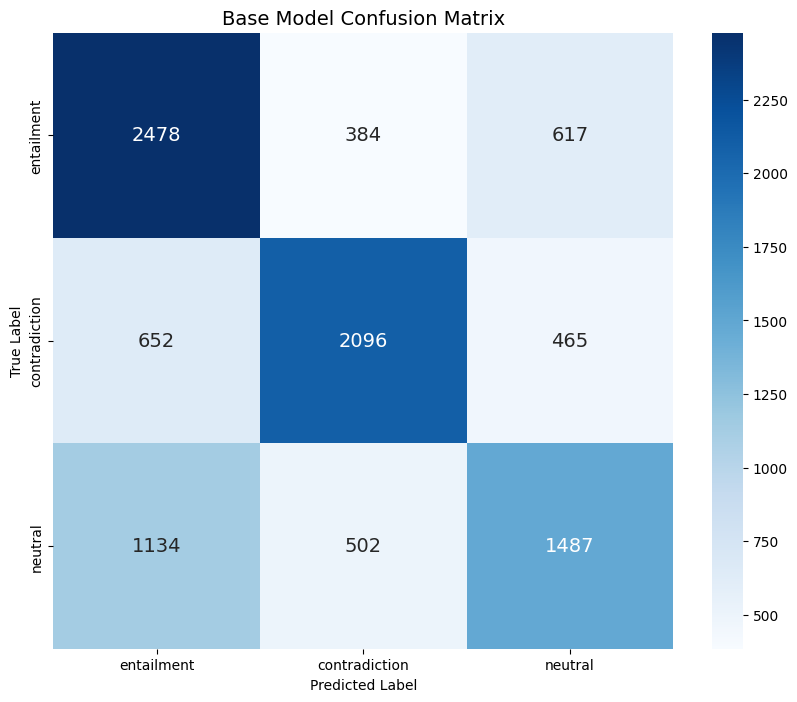

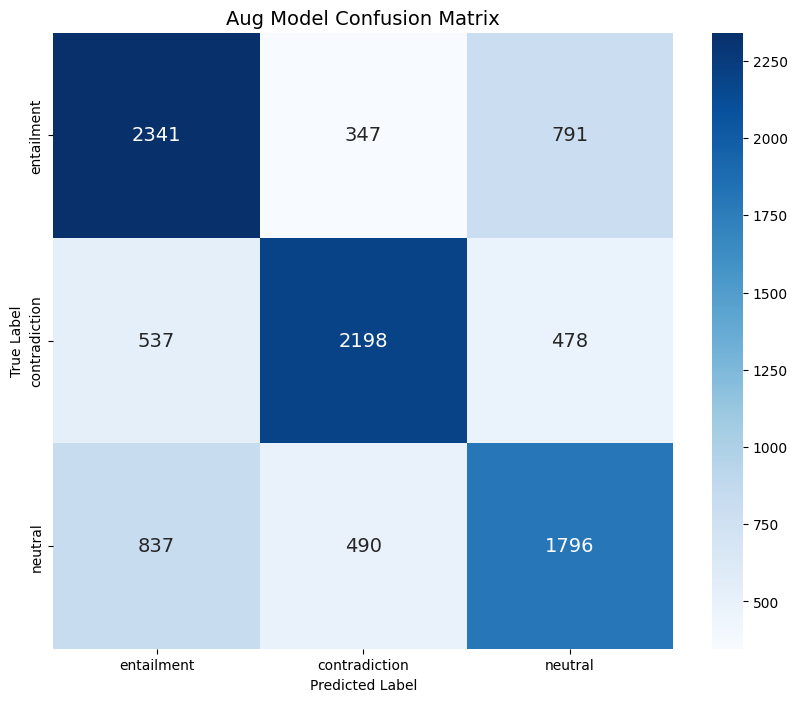

array([[2341,  347,  791],
       [ 537, 2198,  478],
       [ 837,  490, 1796]])

In [7]:
# the paths store the outputs of the model as a list of lists in the form [sent1, sent2, predicted_label, true_label]
# load the data
with open(base_model_correct_outputs, "r") as json_file:
    base_correct_preds = json.load(json_file)
with open(base_model_wrong_outputs, "r") as json_file:
    base_wrong_preds = json.load(json_file)
with open(aug_model_correct_outputs, "r") as json_file:
    aug_correct_preds = json.load(json_file)
with open(aug_model_wrong_outputs, "r") as json_file:
    aug_wrong_preds = json.load(json_file)

print(f"Base model correct predictions: {len(base_correct_preds)}")
print(f"Base model wrong predictions: {len(base_wrong_preds)}")
print(f"Aug model correct predictions: {len(aug_correct_preds)}")
print(f"Aug model wrong predictions: {len(aug_wrong_preds)}")

generate_confusion_matrix(base_correct_preds+base_wrong_preds, title="Base Model Confusion Matrix")
generate_confusion_matrix(aug_correct_preds+aug_wrong_preds, title="Aug Model Confusion Matrix")

In [8]:
# correct and wrong predictions for the base model (for viz purposes)
print(f"\n\nCorrect Predictions")
correct_predictions_base_df = pd.DataFrame(base_correct_preds, columns=['Sentence 1', 'Sentence 2', 'Predicted Label', 'True Label'])
display(correct_predictions_base_df.head())
print(f"\n\nWrong Predictions")
wrong_predictions_base_df = pd.DataFrame(base_wrong_preds, columns=['Sentence 1', 'Sentence 2', 'Predicted Label', 'True Label'])
wrong_predictions_base_df.head()



Correct Predictions


Sentence 1  \
0             This is one of the reasons we're growing too weak to fight the Satheri.  "What's wrong with a ceremony of worship, if you must worship your eggshell?" Dave asked.   
1                                                            This makes it incumbent on the government to create incentives to recruit new employees and retain older employees.   
2                                                                                                             'So I assume he hacked into the autopilot and reprogrammed it to-'   
3                                                                                                                                             I'm not interested in tactics, Al.   
4  Michael B. Wachter of the University of Pennsylvania and his colleagues conclude that there is a wage and fringe benefit premium for the postal bargaining labor force of 29.   

                                                                                 Sentence 2  \
0  "We shouldn't worship our eggshells, why do we even have ceremonies at all?" asked Dave.   
1                  The government needs to create incentives to get and retain employees.     
2                                                  I assumed he reprogrammed the autopilot.   
3                                                  The author is not interested in tactics.   
4                             Wachter teaches economics at the University of Pennsylvania.    

  Predicted Label     True Label  
0   contradiction  contradiction  
1      entailment     entailment  
2      entailment     entailment  
3      entailment     entailment  
4         neutral        neutral



Wrong Predictions


Sentence 1  \
0  the only problem is it's not large enough it only holds about i think they squeezed when Ryan struck out his five thousandth player they they squeezed about forty thousand people in there   
1                                                                                        yes i i always turn on the TV set and it seems like i catch that program in the last five minutes and   
2                                                                                          And if they did come, as remote as that is, you and your men look strong enough to handle anything.   
3                                                                                                                                                                     um-hum with the ice yeah   
4                                                                                                                                            Views from  Implementation Research in Education.   

                                                                 Sentence 2  \
0                                                   It holds 70,000 people.   
1  I often find myself catching only the last five minutes of that program.   
2                                                    The men were warriors.   
3                                      Correct with the frozen water (ice).   
4                                     Views on using research in education    

  Predicted Label     True Label  
0      entailment  contradiction  
1   contradiction     entailment  
2      entailment        neutral  
3   contradiction     entailment  
4   contradiction     entailment

In [9]:
# correct and wrong predictions for the aug model (for viz purposes)
print(f"\n\nCorrect Predictions")
correct_predictions_aug_df = pd.DataFrame(aug_correct_preds, columns=['Sentence 1', 'Sentence 2', 'Predicted Label', 'True Label'])
display(correct_predictions_aug_df.head())
print(f"\n\nWrong Predictions")
wrong_predictions_aug_df = pd.DataFrame(aug_wrong_preds, columns=['Sentence 1', 'Sentence 2', 'Predicted Label', 'True Label'])
wrong_predictions_aug_df.head()



Correct Predictions


Sentence 1  \
0                                                      MC2000-2, was initially considered and recommended by the Commission under the market test rules.   
1  Additionally, GAO's FederalInformationSystemControlsAuditManualis now used by most major federal audit entities to evaluate computerrelated controls.   
2                                                                                                                                 Monday's Question (No.   
3                                                                      You did not understand that he believed Mademoiselle Cynthia guilty of the crime?   
4                                                          On the Use of Generalized Additive Models in Time-Series Studies of Air Pollution and Health.   

                                                        Sentence 2  \
0                  MC2000-2 was not recommended by the Commission.   
1  GAO's system is ranked the best by most federal audit entities.   
2                 There was a question for the audience on Monday.   
3    He believed Mademoiselle Cynthia innocent and you were aware?   
4                            Pollution does not occur in the air.    

  Predicted Label     True Label  
0   contradiction  contradiction  
1         neutral        neutral  
2         neutral        neutral  
3   contradiction  contradiction  
4   contradiction  contradiction



Wrong Predictions


Sentence 1  \
0                                                                                                                                                                                                      profit rather   
1                                                                                                          The organizations usually allowed individual members who had changed employers to continue participation.   
2                                                                                                                                                 The strychnine had been found in a drawer in the prisoner's room.    
3                                                                                                         Then, all the time, it was in the spill vase in Mrs. Inglethorp's bedroom, under our very noses? I cried.    
4  yeah yeah uh-huh yeah we we saw that one uh we find that uh that uh if you can get into those dollar movies you know they're uh they're a dollar and a half what is it dollar and a quarter dollar and a half now   

                                                                                                    Sentence 2  \
0                                                                                               Losses rather.   
1  The organizations didn't allow any individual members who are working for others now, to still participate.   
2                                                               There is a drawer in the prisoner's quarters.    
3                                            So it was hidden in another country, impossible for us to locate?   
4                                                                    You can get Flubber at the dollar movies.   

  Predicted Label     True Label  
0      entailment  contradiction  
1      entailment  contradiction  
2         neutral     entailment  
3         neutral  contradiction  
4      entailment        neutral

## [GRAM] Model Visualizations

In [10]:
# gram model paths
gram_base_correct_outputs = './outputs/gram_base_correct_preds.json'
gram_base_wrong_outputs = './outputs/gram_base_wrong_preds.json'
gram_aug_correct_outputs = './outputs/gram_aug_correct_preds.json'
gram_aug_wrong_outputs = './outputs/gram_aug_wrong_preds.json'

Gram Base model correct predictions: 6043
Gram Base model wrong predictions: 3772
Gram Aug model correct predictions: 6323
Gram Aug model wrong predictions: 3492


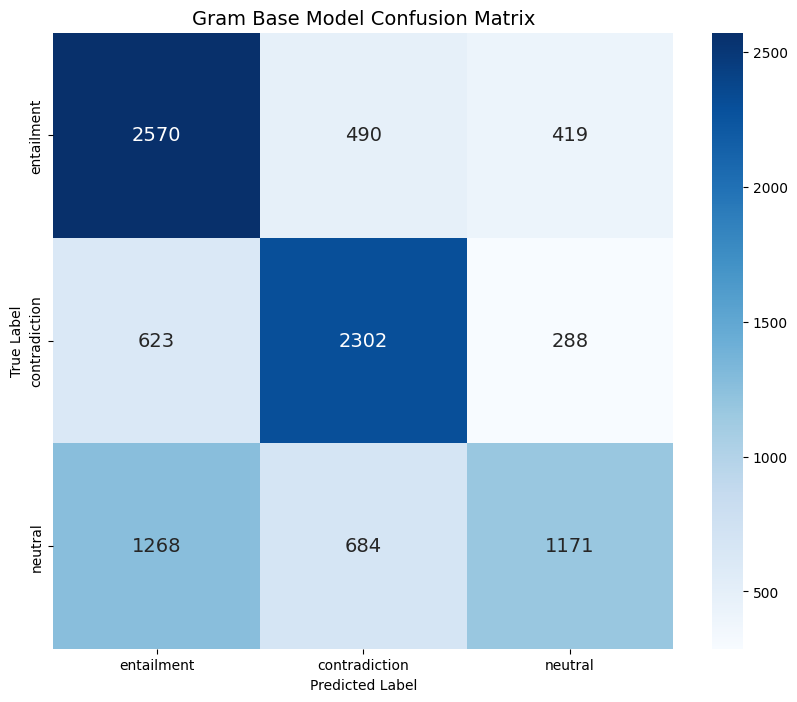

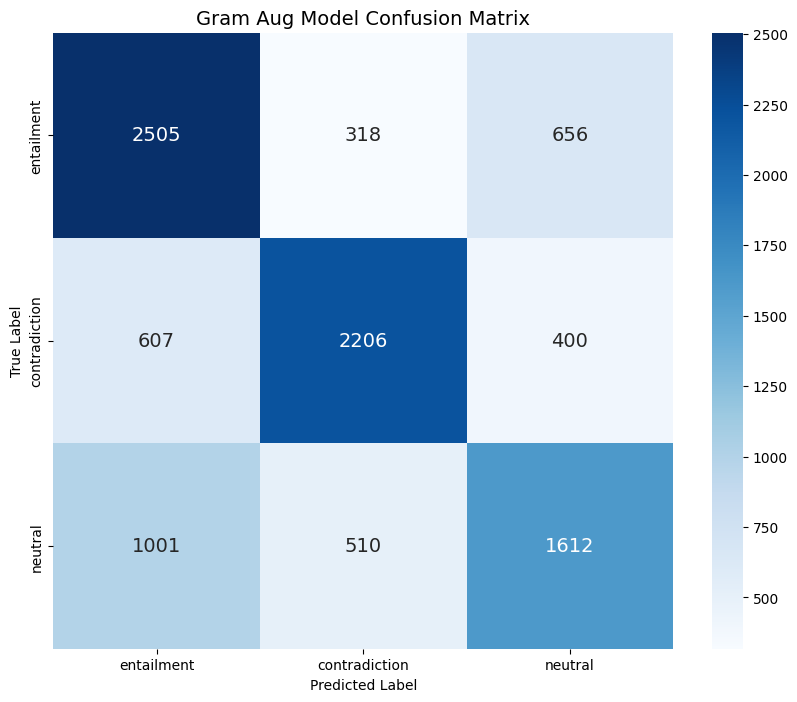

array([[2505,  318,  656],
       [ 607, 2206,  400],
       [1001,  510, 1612]])

In [11]:
# the paths store the outputs of the model as a list of lists in the form [sent1, sent2, predicted_label, true_label]
# load the data
with open(gram_base_correct_outputs, "r") as json_file:
    gram_base_correct_preds = json.load(json_file)
with open(gram_base_wrong_outputs, "r") as json_file:
    gram_base_wrong_preds = json.load(json_file)
with open(gram_aug_correct_outputs, "r") as json_file:
    gram_aug_correct_preds = json.load(json_file)
with open(gram_aug_wrong_outputs, "r") as json_file:
    gram_aug_wrong_preds = json.load(json_file)

print(f"Gram Base model correct predictions: {len(gram_base_correct_preds)}")
print(f"Gram Base model wrong predictions: {len(gram_base_wrong_preds)}")
print(f"Gram Aug model correct predictions: {len(gram_aug_correct_preds)}")
print(f"Gram Aug model wrong predictions: {len(gram_aug_wrong_preds)}")

generate_confusion_matrix(gram_base_correct_preds+gram_base_wrong_preds, title="Gram Base Model Confusion Matrix")
generate_confusion_matrix(gram_aug_correct_preds+gram_aug_wrong_preds, title="Gram Aug Model Confusion Matrix")

In [12]:
# correct and wrong predictions for the base model (for viz purposes)
print(f"\n\nCorrect Predictions")
gram_correct_predictions_base_df = pd.DataFrame(gram_base_correct_preds, columns=['Sentence 1', 'Sentence 2', 'Predicted Label', 'True Label'])
display(gram_correct_predictions_base_df.head())
print(f"\n\nWrong Predictions")
gram_wrong_predictions_base_df = pd.DataFrame(gram_base_wrong_preds, columns=['Sentence 1', 'Sentence 2', 'Predicted Label', 'True Label'])
gram_wrong_predictions_base_df.head()



Correct Predictions


Sentence 1  \
0                                            In Texas, the legislature was instrumental in effecting changes to the state's benefit programs through provisions in several pieces of legislation.   
1                                         It has served as a fortress for the Gallo-Romans, the Visigoths, Franks, and medieval French (you can see the layers of their masonry in the ramparts).   
2                                                                                                                                                                But the third try worked better.   
3                                                                                    The Wither's eldest boy, one of the four of the town militia, saluted in the old style with his stick sword.   
4  The formal splendor of the grounds testify to the 18th-century desire to tame nature, but it is done with such superlative results that one can only be thankful that the work was undertaken.   

                                                                                    Sentence 2  \
0  In Texas, the legislature wasn't an instrumental factor in changes to the benefits program.   
1        Various people have used it as a fortress, as can be seen from the layers of masonry.   
2                                     The third try worked better because we had proper tools.   
3                                                   The boy held a piece of wood in his hand.    
4                                     The grounds were more beautiful than any other location.   

  Predicted Label     True Label  
0   contradiction  contradiction  
1      entailment     entailment  
2         neutral        neutral  
3      entailment     entailment  
4         neutral        neutral



Wrong Predictions


Sentence 1  \
0                                                                                                                                                                                                                                                                                                                                                                          All of our many earnest experiments produced results in line with random chance, they conclude.   
1                                                                                                                                                                                                                                                                       Horwitz makes us see that the pinched circumstances of their lives are not so different from the conditions of their ancestors, dirt-poor yeoman farmers who seldom saw, much less owned, a slave.   
2  and have been back and every now and then some news filters in that they went to see some of the old things and of course the savings and loan program um that was that you know that that just continued to grow in fact after my group i mean we were just a very small specialized group too to get that going and spread and then of course Peace Corps bowed out of that because that's uh uh something that nationalized very quickly and the same with the coops   
3                                                                                                                                                                                                                                                                                                                                                                                                                                                          oh does it sure   
4                                                                                                                                                                                                                                                                                                                                   No money no results!" Another voice which Tommy rather thought was that of Boris replied: "Will you guarantee that there ARE results?"   

                                                                                        Sentence 2  \
0                              The experiments proved that it was no different that random chance.   
1              Their ancestors were poor farmers that never owned a slave and rarely even saw one.   
2  I try to keep up with the program but since I left the Peace Corps I just do not have the time.   
3                                                                   oh, does it do that? of course   
4                                           You can't guarantee there will be results with money.    

  Predicted Label     True Label  
0   contradiction     entailment  
1   contradiction     entailment  
2      entailment        neutral  
3         neutral     entailment  
4      entailment  contradiction

# Negation-Only Results

In [13]:
# look in each file in outputs folder and compare to neg_only_dev_matched.json

# load neg_only_dev_matched.json
neg_tester_path = './multinli_1.0/neg_only_dev_matched.json'
if os.path.exists(neg_tester_path):
    with open(neg_tester_path, "r") as json_file:
        loaded_data = json.load(json_file)
    neg_dev_data = [Datum.from_dict(data) for data in loaded_data]


# # make balanced 500 examples from neg_dev_data
# nd_contradictions = []
# nd_entailments = []
# nd_neutrals = []
# for datum in neg_dev_data:
#     if datum.get_gold_label() == "contradiction":
#         nd_contradictions.append(datum)
#     elif datum.get_gold_label() == "entailment":
#         nd_entailments.append(datum)
#     else:
#         nd_neutrals.append(datum)

# nd_balanced = nd_contradictions[:500] + nd_entailments[:500] + nd_neutrals[:500]

# for each set of predictions in the outputs folder, get only the subset of them which contain negations (sentences appear in the neg_only_dev_matched)
neg_dev = []
for datum in neg_dev_data:
    neg_dev.append((datum.get_sent1(), datum.get_sent2()))


def check_neg_dev_data(data):
    neg_matches = []
    for datum in data:
        if (datum[0], datum[1]) in neg_dev:
            neg_matches.append(datum)
    return neg_matches

def check_pos_dev_data(data):
    pos_matches = []
    for datum in data:
        if (datum[0], datum[1]) not in neg_dev:
            pos_matches.append(datum)
    return pos_matches


base_correct_preds_neg = check_neg_dev_data(base_correct_preds)
base_wrong_preds_neg = check_neg_dev_data(base_wrong_preds)
aug_correct_preds_neg = check_neg_dev_data(aug_correct_preds)
aug_wrong_preds_neg = check_neg_dev_data(aug_wrong_preds)

gram_base_correct_preds_neg = check_neg_dev_data(gram_base_correct_preds)
gram_base_wrong_preds_neg = check_neg_dev_data(gram_base_wrong_preds)
gram_aug_correct_preds_neg = check_neg_dev_data(gram_aug_correct_preds)
gram_aug_wrong_preds_neg = check_neg_dev_data(gram_aug_wrong_preds)

# print("Negation Only Data:")
# print(f"Base model correct negation predictions: {len(base_correct_preds_neg)} out of {len(neg_dev)}")
# print(f"Base model wrong negation predictions: {len(base_wrong_preds_neg)} out of {len(neg_dev)}")
# print(f"Aug model correct negation predictions: {len(aug_correct_preds_neg)} out of {len(neg_dev)}")
# print(f"Aug model wrong negation predictions: {len(aug_wrong_preds_neg)} out of {len(neg_dev)}")

# print(f"Gram Base model correct negation predictions: {len(gram_base_correct_preds_neg)} out of {len(neg_dev)}")
# print(f"Gram Base model wrong negation predictions: {len(gram_base_wrong_preds_neg)} out of {len(neg_dev)}")
# print(f"Gram Aug model correct negation predictions: {len(gram_aug_correct_preds_neg)} out of {len(neg_dev)}")
# print(f"Gram Aug model wrong negation predictions: {len(gram_aug_wrong_preds_neg)} out of {len(neg_dev)}")

base_correct_preds_pos = check_pos_dev_data(base_correct_preds)
base_wrong_preds_pos = check_pos_dev_data(base_wrong_preds)
aug_correct_preds_pos = check_pos_dev_data(aug_correct_preds)
aug_wrong_preds_pos = check_pos_dev_data(aug_wrong_preds)

gram_base_correct_preds_pos = check_pos_dev_data(gram_base_correct_preds)
gram_base_wrong_preds_pos = check_pos_dev_data(gram_base_wrong_preds)
gram_aug_correct_preds_pos = check_pos_dev_data(gram_aug_correct_preds)
gram_aug_wrong_preds_pos = check_pos_dev_data(gram_aug_wrong_preds)

# print("\nPositive Only Data:")
# print(f"Base model correct positive predictions: {len(base_correct_preds_pos)} out of {len(matched_data)-len(neg_dev)}")
# print(f"Base model wrong positive predictions: {len(base_wrong_preds_pos)} out of {len(matched_data)-len(neg_dev)}")
# print(f"Aug model correct positive predictions: {len(aug_correct_preds_pos)} out of {len(matched_data)-len(neg_dev)}")
# print(f"Aug model wrong positive predictions: {len(aug_wrong_preds_pos)} out of {len(matched_data)-len(neg_dev)}")

# print(f"Gram Base model correct positive predictions: {len(gram_base_correct_preds_pos)} out of {len(matched_data)-len(neg_dev)}")
# print(f"Gram Base model wrong positive predictions: {len(gram_base_wrong_preds_pos)} out of {len(matched_data)-len(neg_dev)}")
# print(f"Gram Aug model correct positive predictions: {len(gram_aug_correct_preds_pos)} out of {len(matched_data)-len(neg_dev)}")
# print(f"Gram Aug model wrong positive predictions: {len(gram_aug_wrong_preds_pos)} out of {len(matched_data)-len(neg_dev)}")

In [14]:

print(f'The aug model improved the base model by {len(aug_correct_preds_neg) - len(base_correct_preds_neg)} negation predictions and {len(aug_correct_preds_pos) - len(base_correct_preds_pos)} positive predictions')
print(f'The gram aug model improved the gram base model by {len(gram_aug_correct_preds_neg) - len(gram_base_correct_preds_neg)} negation predictions and {len(gram_aug_correct_preds_pos) - len(gram_base_correct_preds_pos)} positive predictions')
print(f'--> relative to {len(neg_dev)} negation examples and {len(matched_data)-len(neg_dev)} positive examples')
base_neg_improvement = round(((len(aug_correct_preds_neg) - len(base_correct_preds_neg)) / len(base_correct_preds_neg)) * 100,2)
base_pos_improvement = round(((len(aug_correct_preds_pos) - len(base_correct_preds_pos)) / len(base_correct_preds_pos)) * 100,2)
gram_base_neg_improvement = round(((len(gram_aug_correct_preds_neg) - len(gram_base_correct_preds_neg)) / len(gram_base_correct_preds_neg)) * 100,2)
gram_base_pos_improvement = round(((len(gram_aug_correct_preds_pos) - len(gram_base_correct_preds_pos)) / len(gram_base_correct_preds_pos)) * 100,2)

print(f'\nThe base model improved by {base_neg_improvement}% on negation predictions and {base_pos_improvement}% on positive predictions with augmentation')
print(f'The gram base model improved by {gram_base_neg_improvement}% on negation predictions and {gram_base_pos_improvement}% on positive predictions with augmentation')

# print classification reports for each model on the positive and negative subsets
# print("\nBase Model Classification Report (Positive Examples)")
# print(classification_report([labels.index(true_label) for _, _, _, true_label in base_correct_preds_pos+base_wrong_preds_pos], [labels.index(predicted_label) for _, _, predicted_label, _ in base_correct_preds_pos+base_wrong_preds_pos], target_names=labels))
print("\nMACRO F1")
print("Base Model (Negation Examples):")
# print(classification_report([labels.index(true_label) for _, _, _, true_label in base_correct_preds_neg+base_wrong_preds_neg], [labels.index(predicted_label) for _, _, predicted_label, _ in base_correct_preds_neg+base_wrong_preds_neg], target_names=labels))
print(round(f1_score([labels.index(true_label) for _, _, _, true_label in base_correct_preds_neg+base_wrong_preds_neg], [labels.index(predicted_label) for _, _, predicted_label, _ in base_correct_preds_neg+base_wrong_preds_neg], average='macro'),3))
      
# print("\nAug Model Classification Report (Positive Examples)")
# print(classification_report([labels.index(true_label) for _, _, _, true_label in aug_correct_preds_pos+aug_wrong_preds_pos], [labels.index(predicted_label) for _, _, predicted_label, _ in aug_correct_preds_pos+aug_wrong_preds_pos], target_names=labels))
print("Aug Model (Negation Examples):")
# print(classification_report([labels.index(true_label) for _, _, _, true_label in aug_correct_preds_neg+aug_wrong_preds_neg], [labels.index(predicted_label) for _, _, predicted_label, _ in aug_correct_preds_neg+aug_wrong_preds_neg], target_names=labels))
print(round(f1_score([labels.index(true_label) for _, _, _, true_label in aug_correct_preds_neg+aug_wrong_preds_neg], [labels.index(predicted_label) for _, _, predicted_label, _ in aug_correct_preds_neg+aug_wrong_preds_neg], average='macro'),3))

# print("\nGram Base Model Classification Report (Positive Examples)")
# print(classification_report([labels.index(true_label) for _, _, _, true_label in gram_base_correct_preds_pos+gram_base_wrong_preds_pos], [labels.index(predicted_label) for _, _, predicted_label, _ in gram_base_correct_preds_pos+gram_base_wrong_preds_pos], target_names=labels))
print("Gram Base Model (Negation Examples):")
# print(classification_report([labels.index(true_label) for _, _, _, true_label in gram_base_correct_preds_neg+gram_base_wrong_preds_neg], [labels.index(predicted_label) for _, _, predicted_label, _ in gram_base_correct_preds_neg+gram_base_wrong_preds_neg], target_names=labels))
print(round(f1_score([labels.index(true_label) for _, _, _, true_label in gram_base_correct_preds_neg+gram_base_wrong_preds_neg], [labels.index(predicted_label) for _, _, predicted_label, _ in gram_base_correct_preds_neg+gram_base_wrong_preds_neg], average='macro'),3))

# print("\nGram Aug Model Classification Report (Positive Examples)")
# print(classification_report([labels.index(true_label) for _, _, _, true_label in gram_aug_correct_preds_pos+gram_aug_wrong_preds_pos], [labels.index(predicted_label) for _, _, predicted_label, _ in gram_aug_correct_preds_pos+gram_aug_wrong_preds_pos], target_names=labels))
print("Gram Aug Model (Negation Examples):")
# print(classification_report([labels.index(true_label) for _, _, _, true_label in gram_aug_correct_preds_neg+gram_aug_wrong_preds_neg], [labels.index(predicted_label) for _, _, predicted_label, _ in gram_aug_correct_preds_neg+gram_aug_wrong_preds_neg], target_names=labels))
print(round(f1_score([labels.index(true_label) for _, _, _, true_label in gram_aug_correct_preds_neg+gram_aug_wrong_preds_neg], [labels.index(predicted_label) for _, _, predicted_label, _ in gram_aug_correct_preds_neg+gram_aug_wrong_preds_neg], average='macro'),3))


The aug model improved the base model by 50 negation predictions and 224 positive predictions
The gram aug model improved the gram base model by 65 negation predictions and 215 positive predictions
--> relative to 2371 negation examples and 7444 positive examples

The base model improved by 3.16% on negation predictions and 5.0% on positive predictions with augmentation
The gram base model improved by 4.13% on negation predictions and 4.81% on positive predictions with augmentation

MACRO F1
Base Model (Negation Examples):
0.61
Aug Model (Negation Examples):
0.633
Gram Base Model (Negation Examples):
0.59
Gram Aug Model (Negation Examples):
0.636


## confusion matrices for negation only and positive only examples from dev set

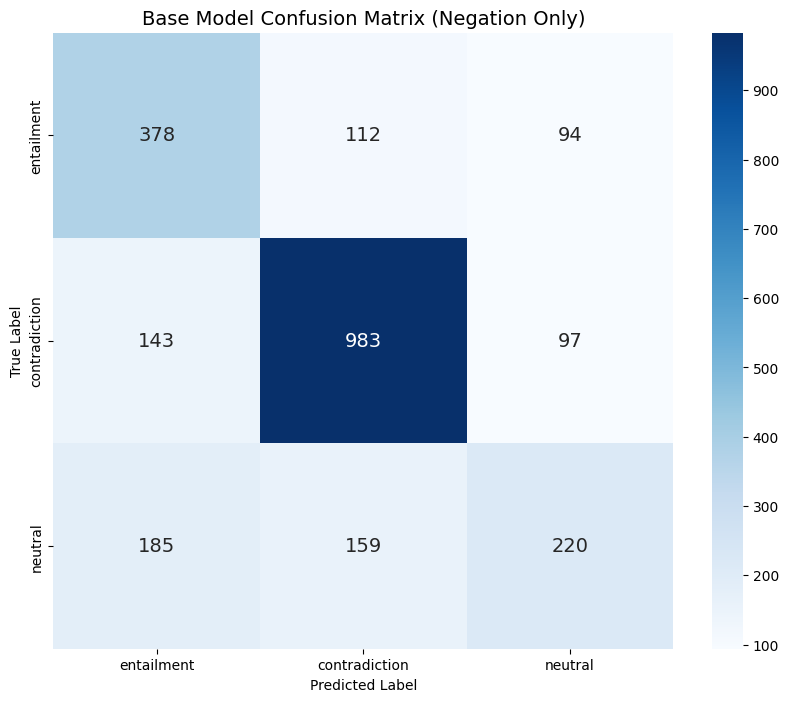

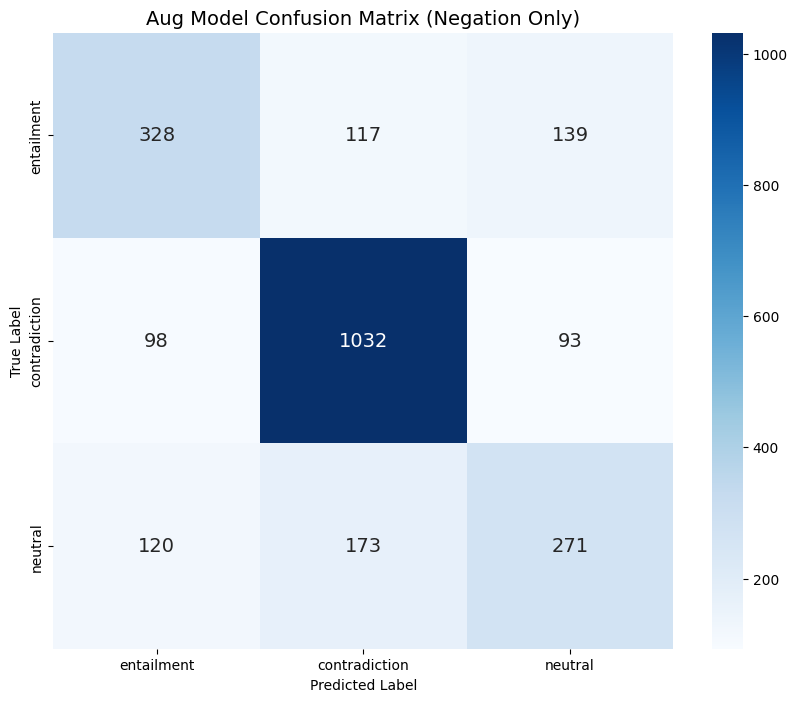

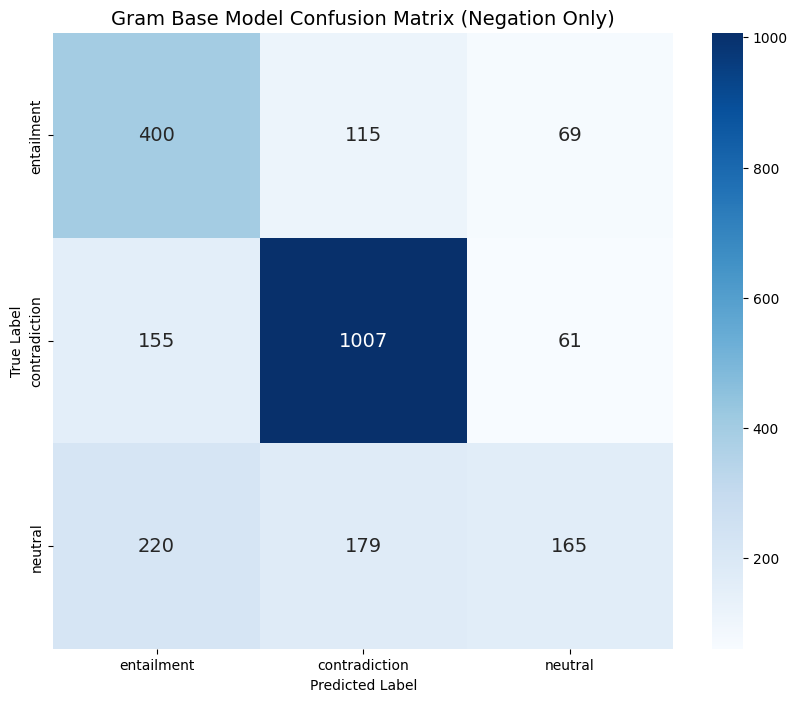

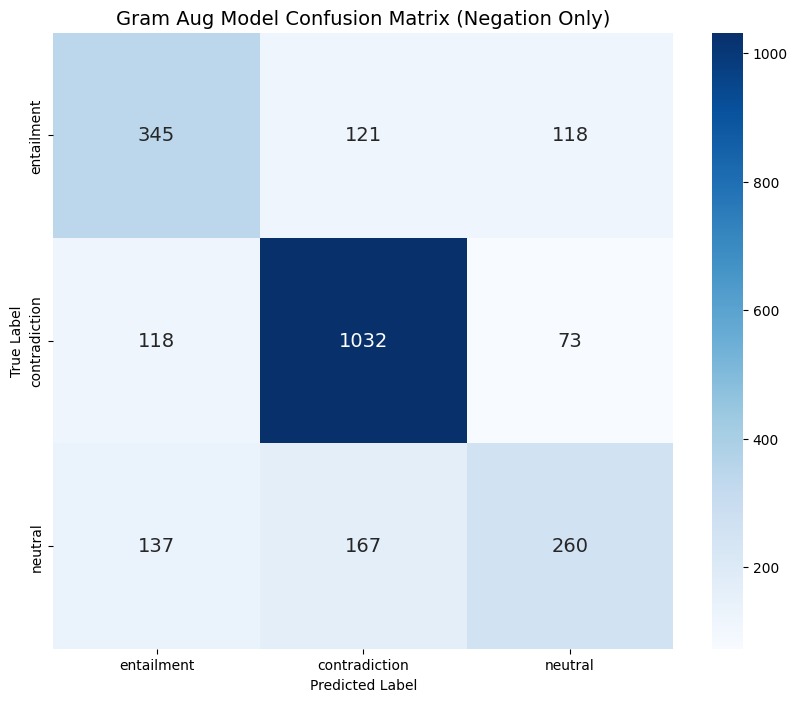

array([[ 345,  121,  118],
       [ 118, 1032,   73],
       [ 137,  167,  260]])

In [15]:
# generate confusion matrices for the negation only data
generate_confusion_matrix(base_correct_preds_neg+base_wrong_preds_neg, title="Base Model Confusion Matrix (Negation Only)")
generate_confusion_matrix(aug_correct_preds_neg+aug_wrong_preds_neg, title="Aug Model Confusion Matrix (Negation Only)")
generate_confusion_matrix(gram_base_correct_preds_neg+gram_base_wrong_preds_neg, title="Gram Base Model Confusion Matrix (Negation Only)")
generate_confusion_matrix(gram_aug_correct_preds_neg+gram_aug_wrong_preds_neg, title="Gram Aug Model Confusion Matrix (Negation Only)")

# generate confusion matrices for the positive only data
# generate_confusion_matrix(base_correct_preds_pos+base_wrong_preds_pos, title="Base Model Confusion Matrix (Positive Only)")
# generate_confusion_matrix(aug_correct_preds_pos+aug_wrong_preds_pos, title="Aug Model Confusion Matrix (Positive Only)")
# generate_confusion_matrix(gram_base_correct_preds_pos+gram_base_wrong_preds_pos, title="Gram Base Model Confusion Matrix (Positive Only)")
# generate_confusion_matrix(gram_aug_correct_preds_pos+gram_aug_wrong_preds_pos, title="Gram Aug Model Confusion Matrix (Positive Only)")

# Model Differentials

In [16]:
def find_incorrect_predictions(contradictions, entailments, neutrals, contradictions2, entailments2, neutrals2):
    # base's incorrect predictions for contradictions
    base_incorrect_contradictions = []
    for index, row in contradictions.iterrows():
        base_incorrect_contradictions.append(row['Base Predicted'])

    # base's incorrect predictions for entailments
    base_incorrect_entailments = []
    for index, row in entailments.iterrows():
        base_incorrect_entailments.append(row['Base Predicted'])

    # base's incorrect predictions for neutrals
    base_incorrect_neutrals = []
    for index, row in neutrals.iterrows():
        base_incorrect_neutrals.append(row['Base Predicted'])

    # use a counter to count the number of each incorrect prediction
    base_incorrect_contradictions_count = Counter(base_incorrect_contradictions)
    base_incorrect_entailments_count = Counter(base_incorrect_entailments)
    base_incorrect_neutrals_count = Counter(base_incorrect_neutrals)

    # print(f"{model1_name} incorrectly predicted contradictions as:")
    # print(base_incorrect_contradictions_count)
    # print(f"\n{model1_name} incorrectly predicted entailments as:")
    # print(base_incorrect_entailments_count)
    # print(f"\n{model1_name} incorrectly predicted neutrals as:")
    # print(base_incorrect_neutrals_count)


    # aug's incorrect predictions for contradictions

    aug_incorrect_contradictions = []
    for index, row in contradictions2.iterrows():
        aug_incorrect_contradictions.append(row['Aug Predicted'])
    aug_incorrect_entailments = []
    for index, row in entailments2.iterrows():
        aug_incorrect_entailments.append(row['Aug Predicted'])
    aug_incorrect_neutrals = []
    for index, row in neutrals2.iterrows():
        aug_incorrect_neutrals.append(row['Aug Predicted'])

    aug_incorrect_contradictions_count = Counter(aug_incorrect_contradictions)
    aug_incorrect_entailments_count = Counter(aug_incorrect_entailments)
    aug_incorrect_neutrals_count = Counter(aug_incorrect_neutrals)

    # print(f"\n\n{model2_name} incorrectly predicted contradictions as:")
    # print(aug_incorrect_contradictions_count)
    # print(f"\n{model2_name} incorrectly predicted entailments as:")
    # print(aug_incorrect_entailments_count)
    # print(f"\n{model2_name} incorrectly predicted neutrals as:")
    # print(aug_incorrect_neutrals_count)

    return base_incorrect_contradictions_count, base_incorrect_entailments_count, base_incorrect_neutrals_count, aug_incorrect_contradictions_count, aug_incorrect_entailments_count, aug_incorrect_neutrals_count

In [17]:
def get_model_diffs(model1_correct_preds, model1_wrong_preds, model2_correct_preds, model2_wrong_preds, model1_name, model2_name):
    # get examples where the aug model gets it right but base model gets it wrong
    correct_predictions_aug_wrong_base = []
    sentences_list = []
    for pred in model2_correct_preds:
        # if sent1 and sent2 from pred are in wrong_predictions
        sentences_list.append((pred[0], pred[1]))
    for pred in model1_wrong_preds:
        if (pred[0], pred[1]) in sentences_list:
            correct_predictions_aug_wrong_base.append(pred)

    #make a df
    correct_predictions_aug_wrong_base_df = pd.DataFrame(correct_predictions_aug_wrong_base, columns=['Sentence 1', 'Sentence 2', 'Base Predicted', 'True Label (aug right)'])

    # find the number of contradictions, entailments and neutrals that the base model got wrong but the aug model got right
    contradictions = correct_predictions_aug_wrong_base_df[correct_predictions_aug_wrong_base_df['True Label (aug right)'] == 'contradiction']
    entailments = correct_predictions_aug_wrong_base_df[correct_predictions_aug_wrong_base_df['True Label (aug right)'] == 'entailment']
    neutrals = correct_predictions_aug_wrong_base_df[correct_predictions_aug_wrong_base_df['True Label (aug right)'] == 'neutral']


    # get examples where the base model gets it right but aug model gets it wrong
    correct_predictions_base_wrong_aug = []
    sentences_list = []
    for pred in model1_correct_preds:
        # if sent1 and sent2 from pred are in wrong_predictions_aug
        sentences_list.append((pred[0], pred[1]))
    for pred in model2_wrong_preds:
        if (pred[0], pred[1]) in sentences_list:
            correct_predictions_base_wrong_aug.append(pred)

    #make a df
    correct_predictions_base_wrong_aug_df = pd.DataFrame(correct_predictions_base_wrong_aug, columns=['Sentence 1', 'Sentence 2', 'Aug Predicted', 'True Label (base right)'])

    # find the number of contradictions, entailments and neutrals that the base model got right but the aug model got wrong
    contradictions2 = correct_predictions_base_wrong_aug_df[correct_predictions_base_wrong_aug_df['True Label (base right)'] == 'contradiction']
    entailments2 = correct_predictions_base_wrong_aug_df[correct_predictions_base_wrong_aug_df['True Label (base right)'] == 'entailment']
    neutrals2 = correct_predictions_base_wrong_aug_df[correct_predictions_base_wrong_aug_df['True Label (base right)'] == 'neutral']

    model2ic, model2ie, model2in, model1ic, model1ie, model1in = find_incorrect_predictions(contradictions, entailments, neutrals, contradictions2, entailments2, neutrals2)

    print(f"\n{model1_name} wrong, {model2_name} correct")
    print(f"Contradictions: {len(contradictions)} -- entailment: {model2ic['entailment']} neutral: {model2ic['neutral']}")
    print(f"Entailments: {len(entailments)} -- contradiction: {model2ie['contradiction']} neutral: {model2ie['neutral']}")
    print(f"Neutrals: {len(neutrals)} -- entailment: {model2in['entailment']} contradiction: {model2in['contradiction']}")

    print(f"\n{model2_name} wrong, {model1_name} correct")
    print(f"Contradictions: {len(contradictions2)} -- entailment: {model1ic['entailment']} neutral: {model1ic['neutral']}")
    print(f"Entailments: {len(entailments2)} -- contradiction: {model1ie['contradiction']} neutral: {model1ie['neutral']}")
    print(f"Neutrals: {len(neutrals2)} -- entailment: {model1in['entailment']} contradiction: {model1in['contradiction']}")


    # get examples where both the base model and aug model get it right
    correct_predictions_both = [pred for pred in model1_correct_preds if pred in model2_correct_preds]

    # get examples where both the base model and aug model get it wrong
    wrong_predictions_both = [pred for pred in model1_wrong_preds if pred in model2_wrong_preds]

    print(f"\nBoth models got it right")
    print(f"Total: {len(correct_predictions_both)}")
    print(f"\nBoth models got it wrong")
    print(f"Total: {len(wrong_predictions_both)}")
    print(f"\nOne model got it right, the other got it wrong")
    print(f"Total: {len(correct_predictions_aug_wrong_base) + len(correct_predictions_base_wrong_aug)}")

    return model1_name, model2_name, entailments, contradictions, neutrals, entailments2, contradictions2, neutrals2, correct_predictions_aug_wrong_base_df, correct_predictions_base_wrong_aug_df

- These findings suggest that the Base Model struggles more with distinguishing neutrals from entailments, while the Aug Model has a more balanced performance across the labels. The Aug Model's misclassifications are more evenly distributed, indicating that it might be less biased towards a particular label when making mistakes.

In [18]:
def plot_diffs(model1_name, model2_name, entailments, neutrals, contradictions, entailments2, neutrals2, contradictions2):
    e_list = [len(entailments), len(entailments2)]
    n_list = [len(neutrals), len(neutrals2)]
    c_list = [len(contradictions), len(contradictions2)]

    # Create a figure and subplots in a 1x1 grid layout
    fig, ax = plt.subplots(1, 1, figsize=(8, 6))

    # Adjust the width and spacing of the bars
    bar_width = 0.2
    spacing = 0.1

    # Plot data_lists
    ax.bar(np.arange(len(e_list)), e_list, width=bar_width, color='g', alpha=.7, label='Entailments')
    ax.bar(np.arange(len(n_list)) + bar_width, n_list, width=bar_width, color='orange', alpha=.7, label='Neutrals')
    ax.bar(np.arange(len(c_list)) + 2 * bar_width, c_list, width=bar_width, color='red', alpha=.7, label='Contradictions')


    # add labels in middle of each bar
    for i, v in enumerate(e_list):
        ax.text(i, v/2, str(v), color='black', ha='center')
    for i, v in enumerate(n_list):
        ax.text(i + bar_width, v/2, str(v), color='black', ha='center')
    for i, v in enumerate(c_list):
        ax.text(i + 2 * bar_width, v/2 , str(v), color='black', ha='center')

    x_tick1 = f'{model1_name} wrong, {model2_name} right'
    x_tick2 = f'{model2_name} wrong, {model1_name} right'

    # Add labels and title
    ax.set_ylabel('Number of predictions')
    ax.set_title('Model diffs (neither both correct, nor both wrong)')
    ax.set_xticks(np.arange(len(e_list)) + bar_width + spacing)
    ax.set_xticklabels([x_tick1, x_tick2])
    ax.legend()

    # Show the plot
    plt.show()


In [19]:
def plot_word_length_diffs(model1_name, model2_name, correct_predictions_base_wrong_aug_df, correct_predictions_aug_wrong_base_df):
    # plot a histogram of the number of words in the sentences, and compare the distributions of the correct and wrong predictions
    # get the number of words in each sentence
    correct_predictions_base_wrong_aug_df['num_words_sent1'] = correct_predictions_base_wrong_aug_df['Sentence 1'].apply(lambda x: len(x.split()))
    correct_predictions_base_wrong_aug_df['num_words_sent2'] = correct_predictions_base_wrong_aug_df['Sentence 2'].apply(lambda x: len(x.split()))

    correct_predictions_aug_wrong_base_df['num_words_sent1'] = correct_predictions_aug_wrong_base_df['Sentence 1'].apply(lambda x: len(x.split()))
    correct_predictions_aug_wrong_base_df['num_words_sent2'] = correct_predictions_aug_wrong_base_df['Sentence 2'].apply(lambda x: len(x.split()))

    # plot histograms

    fig, ax = plt.subplots(1, 2, figsize=(12, 6))

    x_tick1 = f'{model1_name} wrong, {model2_name} right'
    x_tick2 = f'{model2_name} wrong, {model1_name} right'

    ax[0].hist(correct_predictions_aug_wrong_base_df['num_words_sent1'], bins=20, alpha=0.7, color='b', label='Sentence 1')
    ax[0].hist(correct_predictions_aug_wrong_base_df['num_words_sent2'], bins=20, alpha=0.7, color='r', label='Sentence 2')
    ax[0].set_title(x_tick1)
    ax[0].set_xlabel('Number of words')
    ax[0].set_ylabel('Frequency')
    ax[0].legend()

    ax[1].hist(correct_predictions_base_wrong_aug_df['num_words_sent1'], bins=20, alpha=0.7, color='b', label='Sentence 1')
    ax[1].hist(correct_predictions_base_wrong_aug_df['num_words_sent2'], bins=20, alpha=0.7, color='r', label='Sentence 2')
    ax[1].set_title(x_tick2)
    ax[1].set_xlabel('Number of words')
    ax[1].set_ylabel('Frequency')
    ax[1].legend()

    # Show the plot
    plt.show()


In [20]:
# find examples within the model 2 correct, model 1 incorrect predictions where it contains a negation
def neg_diffs(model1_name, model2_name, correct_predictions_aug_wrong_base_df, correct_predictions_base_wrong_aug_df):
    
    x_tick1 = f'{model1_name} wrong, {model2_name} right'
    x_tick2 = f'{model2_name} wrong, {model1_name} right'

    tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
    negations = ['neither', 'never', 'no one', 'nobody', 'none', 'nor', 'nothing', 'nowhere', "isn't", "doesn't", "hasn't", "not", "no", "can't", "won't", "shouldn't", "wouldn't", "couldn't", "don't", "didn't", "aren't", "wasn't", "weren't", "isn't", "aren't", "wasn't", "weren't", "hasn't", "haven't", "hadn't", "won't", "wouldn't", "shan't", "shouldn't", "mustn't", "needn't", "mightn't"]
    num_examples = 0
    for index, row in correct_predictions_aug_wrong_base_df.iterrows():
        if any(negation in tokenizer.tokenize(row['Sentence 1']) for negation in negations) or any(negation in tokenizer.tokenize(row['Sentence 2']) for negation in negations):
            num_examples += 1

    print(f"\nNumber of examples where {x_tick1} that contain a negation: {num_examples}")

    num_examples = 0
    for index, row in correct_predictions_base_wrong_aug_df.iterrows():
        if any(negation in tokenizer.tokenize(row['Sentence 1']) for negation in negations) or any(negation in tokenizer.tokenize(row['Sentence 2']) for negation in negations):
            num_examples += 1

    print(f"Number of examples where {x_tick2} that contain a negation: {num_examples}")

### Base vs Aug (Full test set)


Base Model wrong, Aug Model correct
Contradictions: 197 -- entailment: 99 neutral: 98
Entailments: 199 -- contradiction: 79 neutral: 120
Neutrals: 400 -- entailment: 333 contradiction: 67

Aug Model wrong, Base Model correct
Contradictions: 95 -- entailment: 53 neutral: 42
Entailments: 336 -- contradiction: 52 neutral: 284
Neutrals: 91 -- entailment: 43 contradiction: 48

Both models got it right
Total: 5539

Both models got it wrong
Total: 2716

One model got it right, the other got it wrong
Total: 1318

Number of examples where Base Model wrong, Aug Model right that contain a negation: 174
Number of examples where Aug Model wrong, Base Model right that contain a negation: 124


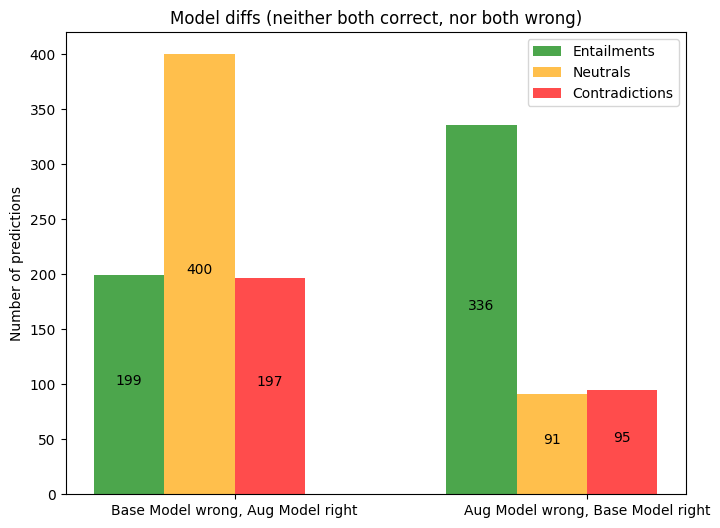

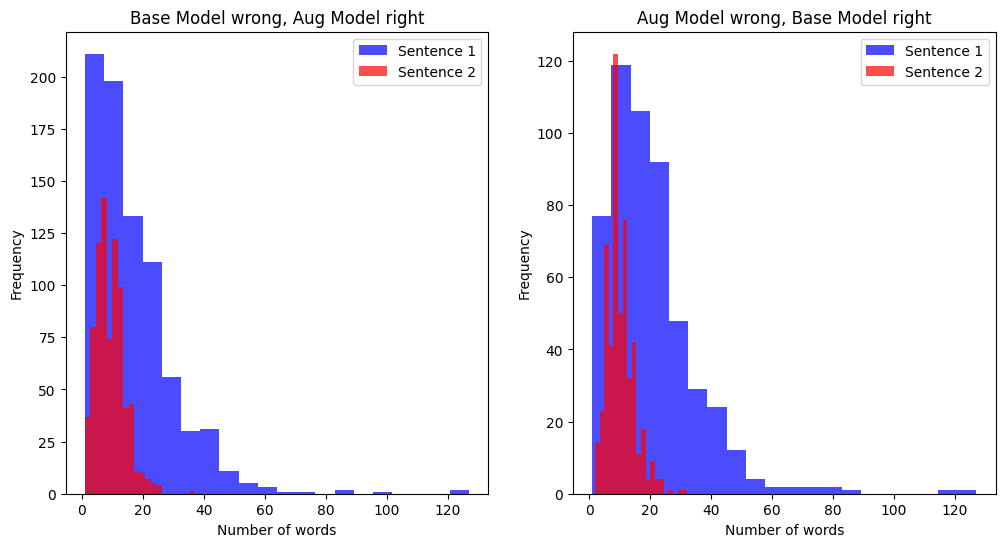

In [21]:
model1_name, model2_name, entailments, contradictions, neutrals, entailments2, contradictions2, neutrals2, correct_predictions_aug_wrong_base_df, correct_predictions_base_wrong_aug_df = get_model_diffs(base_correct_preds, base_wrong_preds, aug_correct_preds, aug_wrong_preds, "Base Model", "Aug Model")
neg_diffs(model1_name, model2_name, correct_predictions_aug_wrong_base_df, correct_predictions_base_wrong_aug_df)
plot_diffs(model1_name, model2_name, entailments, neutrals, contradictions, entailments2, neutrals2, contradictions2)
plot_word_length_diffs(model1_name, model2_name, correct_predictions_base_wrong_aug_df, correct_predictions_aug_wrong_base_df)

In [22]:
# perform a mcnemar's test for statistical significance of model improvement
from statsmodels.stats.contingency_tables import mcnemar

# contingency table: [a, b], [c, d]
# a = both models correct, b = base correct, aug wrong, c = base wrong, aug correct, d = both models wrong

contingency_table = [[5539, 796], [522, 2716]]
result = mcnemar(contingency_table, exact=False)
p_value = "{:e}".format(result.pvalue)

print(f"McNemar's test statistic: {result.statistic:.2f}")
print(f"P-value: {p_value}")
if result.pvalue < 0.05:
    print("improvement is statistically significant")
else:
    print("improvement is not statistically significant")


McNemar's test statistic: 56.55
P-value: 5.486989e-14
improvement is statistically significant


### Base vs Aug (Neg test set)


Base Model wrong, Aug Model correct
Contradictions: 72 -- entailment: 35 neutral: 37
Entailments: 29 -- contradiction: 12 neutral: 17
Neutrals: 73 -- entailment: 60 contradiction: 13

Aug Model wrong, Base Model correct
Contradictions: 23 -- entailment: 13 neutral: 10
Entailments: 79 -- contradiction: 19 neutral: 60
Neutrals: 22 -- entailment: 1 contradiction: 21

Both models got it right
Total: 1457

Both models got it wrong
Total: 559

One model got it right, the other got it wrong
Total: 298

Number of examples where Base Model wrong, Aug Model right that contain a negation: 174
Number of examples where Aug Model wrong, Base Model right that contain a negation: 124


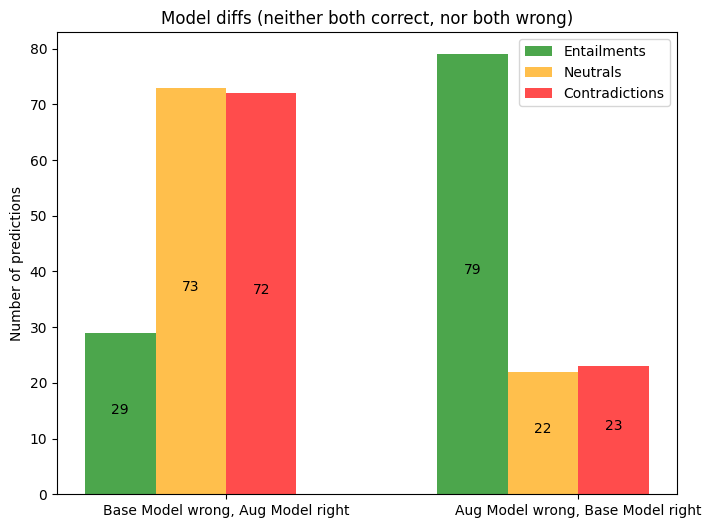

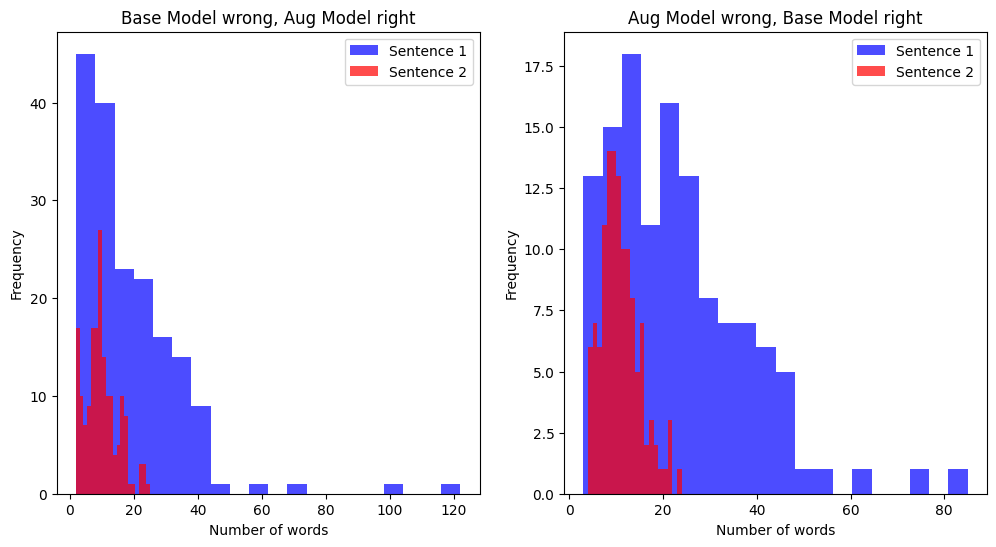

In [23]:
model1_name, model2_name, entailments, contradictions, neutrals, entailments2, contradictions2, neutrals2, correct_predictions_aug_wrong_base_df, correct_predictions_base_wrong_aug_df = get_model_diffs(base_correct_preds_neg, base_wrong_preds_neg, aug_correct_preds_neg, aug_wrong_preds_neg, "Base Model", "Aug Model")
neg_diffs(model1_name, model2_name, correct_predictions_aug_wrong_base_df, correct_predictions_base_wrong_aug_df)
plot_diffs(model1_name, model2_name, entailments, neutrals, contradictions, entailments2, neutrals2, contradictions2)
plot_word_length_diffs(model1_name, model2_name, correct_predictions_base_wrong_aug_df, correct_predictions_aug_wrong_base_df)

# Full dataset versus grammatical dataset -- what are the differences?
- gram set has a more evenly spread training distribution by input sentence length
- full dataset has more examples of actual human speech

In [24]:
# visualize the distribution of sentence lengths in train data and gram train data

# load the train data
train_path = './multinli_1.0/multinli_1.0_train.jsonl'
train = load_data(train_path)

augmented_train_path = './multinli_1.0/augmented_dataset.json'
if os.path.exists(augmented_train_path):
    with open(augmented_train_path, "r") as json_file:
        loaded_data = json.load(json_file)
    augmented_train = [Datum.from_dict(data) for data in loaded_data]

# load the gram train data
gram_train_path = './multinli_1.0/grammatical_dataset.json'
if os.path.exists(gram_train_path):
        with open(gram_train_path, "r") as json_file:
            loaded_data = json.load(json_file)
        gram_train = [Datum.from_dict(data) for data in loaded_data]

train_sent_lengths = []
gram_train_sent_lengths = []
# get the number of words in each sentence
for datum in tqdm(train):
    sent1_num_words = len(datum.get_sent1().split())
    sent2_num_words = len(datum.get_sent2().split())
    train_sent_lengths.append([sent1_num_words, sent2_num_words])

for datum in tqdm(gram_train):
    sent1_num_words = len(datum.get_sent1().split())
    sent2_num_words = len(datum.get_sent2().split())
    gram_train_sent_lengths.append([sent1_num_words, sent2_num_words])

Loaded 392702 data points from ./multinli_1.0/multinli_1.0_train.jsonl
Filtered 0 instances of '-' from ./multinli_1.0/multinli_1.0_train.jsonl



100%|██████████| 237576/237576 [00:00<00:00, 296491.89it/s]


In [25]:
tokenizer = AutoTokenizer.from_pretrained('distilbert/distilbert-base-uncased')

negations = ['neither', 'never', 'no one', 'nobody', 'none', 'nor', 'nothing', 'nowhere', "isn't", "doesn't", "hasn't", "not", "no", "can't", "won't", "shouldn't", "wouldn't", "couldn't", "don't", "didn't", "aren't", "wasn't", "weren't", "isn't", "aren't", "wasn't", "weren't", "hasn't", "haven't", "hadn't", "won't", "wouldn't", "shan't", "shouldn't", "mustn't", "needn't", "mightn't"]

full_dataset_negations = []
augmented_train_negations = []
grammatical_train_negations = []
dev_matched_negations = []

print(f"checking for negation in {len(train)} data points...")
for datum in tqdm(train):
    sent1 = datum.get_sent1()
    sent2 = datum.get_sent2()

    # tokenize the sentences (get word tokens)
    tokens1 = tokenizer.tokenize(sent1)
    tokens2 = tokenizer.tokenize(sent2)
    if any(negation in tokens1 for negation in negations) or any(negation in tokens2 for negation in negations):
        # add datum to new list
        full_dataset_negations.append(datum)

print(f"checking for negation in {len(gram_train)} data points...")
for datum in tqdm(gram_train):
    sent1 = datum.get_sent1()
    sent2 = datum.get_sent2()
    tokens1 = tokenizer.tokenize(sent1)
    tokens2 = tokenizer.tokenize(sent2)
    if any(negation in tokens1 for negation in negations) or any(negation in tokens2 for negation in negations):
        # add datum to new list "grammatical_train_negations"
        grammatical_train_negations.append(datum)

print(f"checking for negation in {len(augmented_train)} data points...")
for datum in tqdm(augmented_train):
    sent1 = datum.get_sent1()
    sent2 = datum.get_sent2()
    tokens1 = tokenizer.tokenize(sent1)
    tokens2 = tokenizer.tokenize(sent2)
    if any(negation in tokens1 for negation in negations) or any(negation in tokens2 for negation in negations):
        # add datum to new list "augmented_train_negations"
        augmented_train_negations.append(datum)

# check the true label of each item in the full_dataset_negations and grammatical_train_negations
full_dataset_negations_labels = [datum.get_gold_label() for datum in full_dataset_negations]
augmented_train_negations_labels = [datum.get_gold_label() for datum in augmented_train_negations]
grammatical_train_negations_labels = [datum.get_gold_label() for datum in grammatical_train_negations]

# run a counter on the labels
full_dataset_negations_labels_count = Counter(full_dataset_negations_labels)
augmented_train_negations_labels_count = Counter(augmented_train_negations_labels)
grammatical_train_negations_labels_count = Counter(grammatical_train_negations_labels)

print(f"\nFull dataset negations:")
print(full_dataset_negations_labels_count)
print(f"\nAugmented train negations:")
print(augmented_train_negations_labels_count)
print(f"\nGrammatical train negations:")
print(grammatical_train_negations_labels_count)

checking for negation in 392702 data points...


  0%|          | 616/392702 [00:00<01:03, 6150.04it/s]

100%|██████████| 392702/392702 [01:06<00:00, 5899.47it/s]


checking for negation in 237576 data points...


100%|██████████| 237576/237576 [00:40<00:00, 5847.79it/s]


checking for negation in 643976 data points...


100%|██████████| 643976/643976 [01:51<00:00, 5771.34it/s]



Full dataset negations:
Counter({'contradiction': 50895, 'neutral': 24780, 'entailment': 21572})

Augmented train negations:
Counter({'contradiction': 69156, 'entailment': 47777, 'neutral': 38315})

Grammatical train negations:
Counter({'contradiction': 29794, 'neutral': 13753, 'entailment': 11540})


Percentage of train data under 25 words: 35.76%
Percentage of gram train data under 25 words: 37.78%


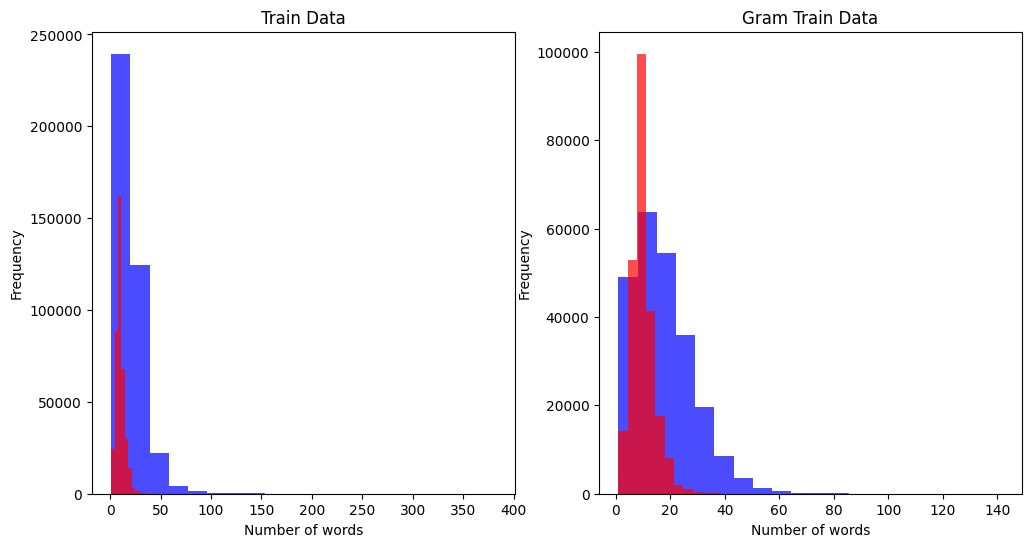

In [26]:
# plot distributions of sentence lengths in training data (for viz)
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].hist([x[0] for x in train_sent_lengths], bins=20, alpha=0.7, color='b', label='Sentence 1')
ax[0].hist([x[1] for x in train_sent_lengths], bins=20, alpha=0.7, color='r', label='Sentence 2')
ax[0].set_ylabel('Frequency')
ax[0].set_xlabel('Number of words')
ax[0].set_title('Train Data')

ax[1].hist([x[0] for x in gram_train_sent_lengths], bins=20, alpha=0.7, color='b', label='Sentence 1')
ax[1].hist([x[1] for x in gram_train_sent_lengths], bins=20, alpha=0.7, color='r', label='Sentence 2')
ax[1].set_ylabel('Frequency')
ax[1].set_xlabel('Number of words')
ax[1].set_title('Gram Train Data')

# what percentage of sentence 1 is under 25 words?
train_under_25 = 0
gram_train_under_25 = 0
for x in train_sent_lengths:
    if x[0] < 25:
        train_under_25 += 1

for x in gram_train_sent_lengths:
    if x[0] < 25:
        gram_train_under_25 += 1

print(f"Percentage of train data under 25 words: {train_under_25 / (len(train_sent_lengths) * 2) * 100:.2f}%")
print(f"Percentage of gram train data under 25 words: {gram_train_under_25 / (len(gram_train_sent_lengths) * 2) * 100:.2f}%")

# GramBase vs base (Full test set)


GramBase Model wrong, Base Model correct
Contradictions: 138 -- entailment: 101 neutral: 37
Entailments: 250 -- contradiction: 136 neutral: 114
Neutrals: 482 -- entailment: 291 contradiction: 191

Base Model wrong, GramBase Model correct
Contradictions: 344 -- entailment: 166 neutral: 178
Entailments: 342 -- contradiction: 106 neutral: 236
Neutrals: 166 -- entailment: 127 contradiction: 39

Both models got it right
Total: 5191

Both models got it wrong
Total: 2566

One model got it right, the other got it wrong
Total: 1722



Number of examples where GramBase Model wrong, Base Model right that contain a negation: 193
Number of examples where Base Model wrong, GramBase Model right that contain a negation: 184


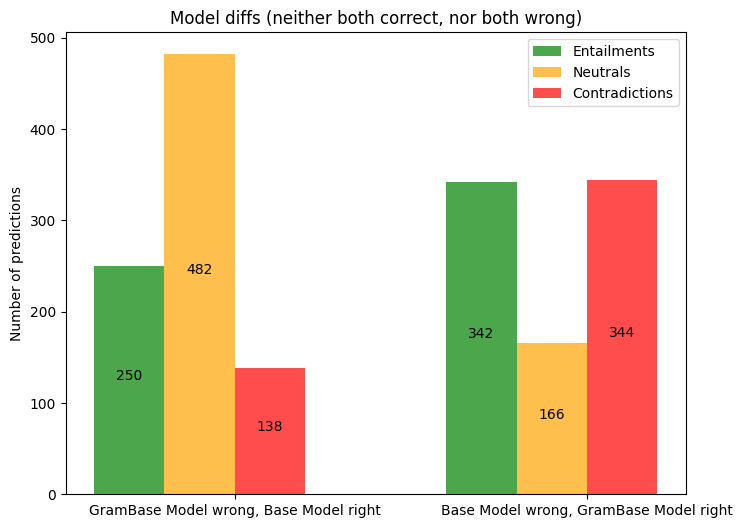

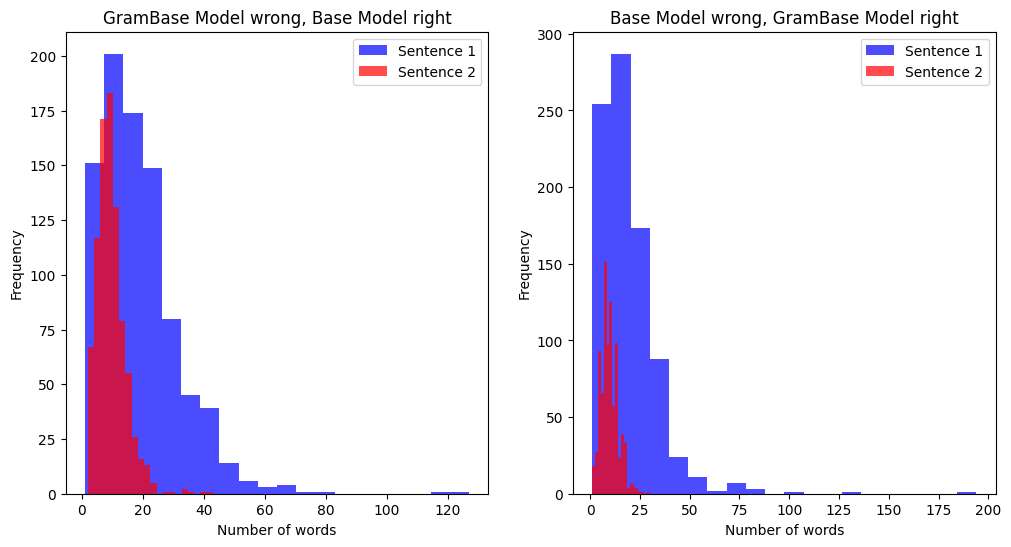

In [27]:
model1_name, model2_name, entailments, contradictions, neutrals, entailments2, contradictions2, neutrals2, correct_predictions_aug_wrong_base_df, correct_predictions_base_wrong_aug_df = get_model_diffs(gram_base_correct_preds, gram_base_wrong_preds, base_correct_preds, base_wrong_preds, "GramBase Model", "Base Model")
neg_diffs(model1_name, model2_name, correct_predictions_aug_wrong_base_df, correct_predictions_base_wrong_aug_df)
plot_diffs(model1_name, model2_name, entailments, neutrals, contradictions, entailments2, neutrals2, contradictions2)
plot_word_length_diffs(model1_name, model2_name, correct_predictions_base_wrong_aug_df, correct_predictions_aug_wrong_base_df)

# GramBase vs Base (neg test set)


GramBase Model wrong, Base Model correct
Contradictions: 57 -- entailment: 45 neutral: 12
Entailments: 52 -- contradiction: 27 neutral: 25
Neutrals: 84 -- entailment: 48 contradiction: 36

Base Model wrong, GramBase Model correct
Contradictions: 81 -- entailment: 37 neutral: 44
Entailments: 74 -- contradiction: 32 neutral: 42
Neutrals: 29 -- entailment: 20 contradiction: 9

Both models got it right
Total: 1388

Both models got it wrong
Total: 545

One model got it right, the other got it wrong
Total: 377

Number of examples where GramBase Model wrong, Base Model right that contain a negation: 193
Number of examples where Base Model wrong, GramBase Model right that contain a negation: 184


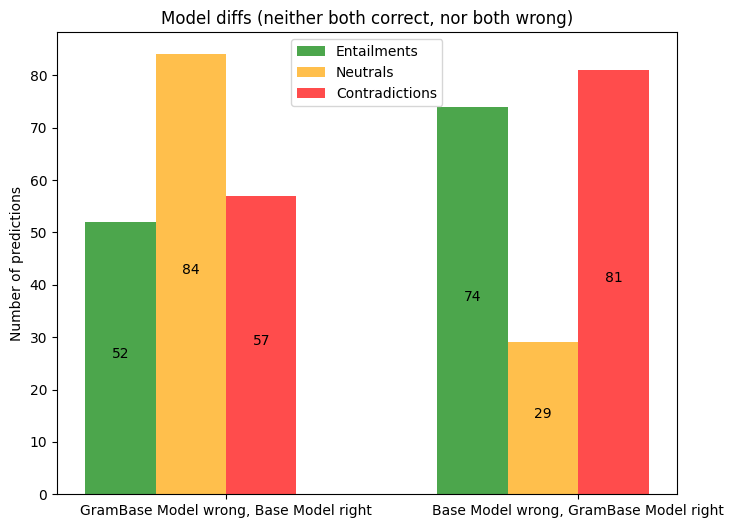

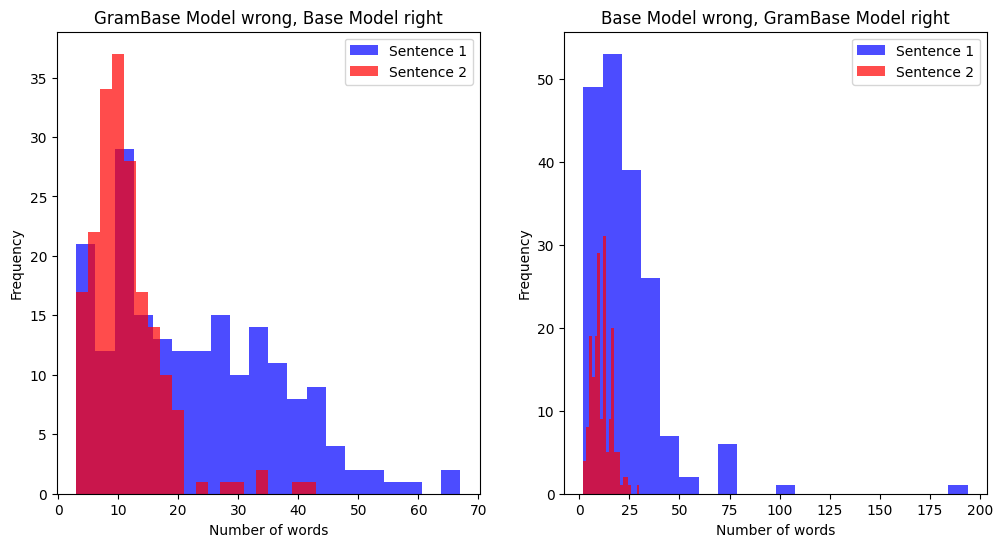

In [28]:
model1_name, model2_name, entailments, contradictions, neutrals, entailments2, contradictions2, neutrals2, correct_predictions_aug_wrong_base_df, correct_predictions_base_wrong_aug_df = get_model_diffs(gram_base_correct_preds_neg, gram_base_wrong_preds_neg, base_correct_preds_neg, base_wrong_preds_neg, "GramBase Model", "Base Model")
neg_diffs(model1_name, model2_name, correct_predictions_aug_wrong_base_df, correct_predictions_base_wrong_aug_df)
plot_diffs(model1_name, model2_name, entailments, neutrals, contradictions, entailments2, neutrals2, contradictions2)
plot_word_length_diffs(model1_name, model2_name, correct_predictions_base_wrong_aug_df, correct_predictions_aug_wrong_base_df)


GramAug Model wrong, Aug Model correct
Contradictions: 46 -- entailment: 27 neutral: 19
Entailments: 55 -- contradiction: 25 neutral: 30
Neutrals: 57 -- entailment: 33 contradiction: 24

Aug Model wrong, GramAug Model correct
Contradictions: 46 -- entailment: 19 neutral: 27
Entailments: 72 -- contradiction: 32 neutral: 40
Neutrals: 46 -- entailment: 23 contradiction: 23

Both models got it right
Total: 1473

Both models got it wrong
Total: 514

One model got it right, the other got it wrong
Total: 322

Number of examples where GramAug Model wrong, Aug Model right that contain a negation: 158
Number of examples where Aug Model wrong, GramAug Model right that contain a negation: 164


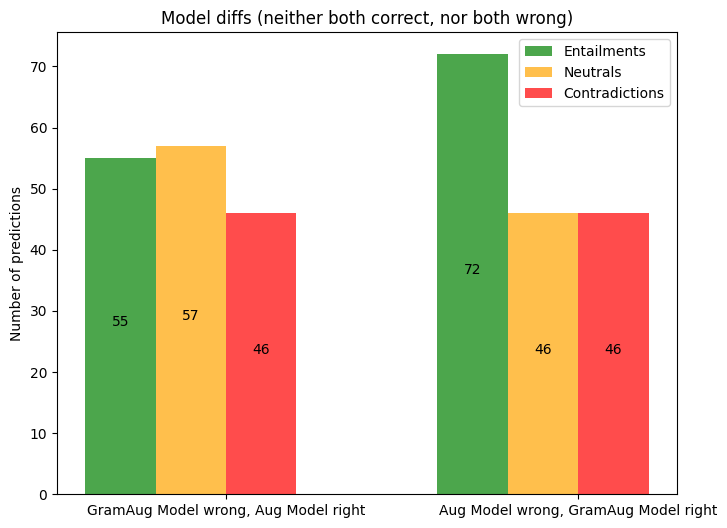

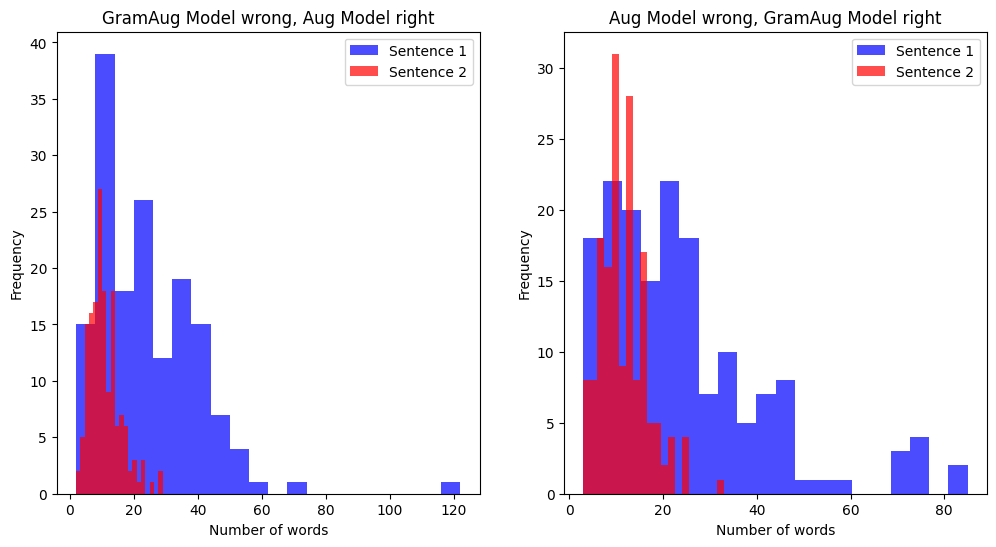

In [29]:
model1_name, model2_name, entailments, contradictions, neutrals, entailments2, contradictions2, neutrals2, correct_predictions_aug_wrong_base_df, correct_predictions_base_wrong_aug_df = get_model_diffs(gram_aug_correct_preds_neg, gram_aug_wrong_preds_neg, aug_correct_preds_neg, aug_wrong_preds_neg, "GramAug Model", "Aug Model")
neg_diffs(model1_name, model2_name, correct_predictions_aug_wrong_base_df, correct_predictions_base_wrong_aug_df)
plot_diffs(model1_name, model2_name, entailments, neutrals, contradictions, entailments2, neutrals2, contradictions2)
plot_word_length_diffs(model1_name, model2_name, correct_predictions_base_wrong_aug_df, correct_predictions_aug_wrong_base_df)


GramBase Model wrong, GramAug Model correct
Contradictions: 124 -- entailment: 81 neutral: 43
Entailments: 290 -- contradiction: 193 neutral: 97
Neutrals: 501 -- entailment: 353 contradiction: 148

GramAug Model wrong, GramBase Model correct
Contradictions: 220 -- entailment: 133 neutral: 87
Entailments: 355 -- contradiction: 63 neutral: 292
Neutrals: 60 -- entailment: 39 contradiction: 21

Both models got it right
Total: 5408

Both models got it wrong
Total: 2552

One model got it right, the other got it wrong
Total: 1550

Number of examples where GramBase Model wrong, GramAug Model right that contain a negation: 207
Number of examples where GramAug Model wrong, GramBase Model right that contain a negation: 142


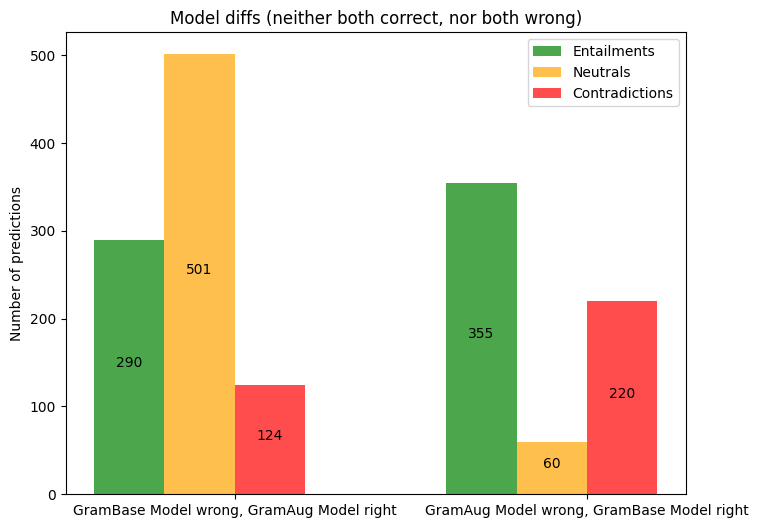

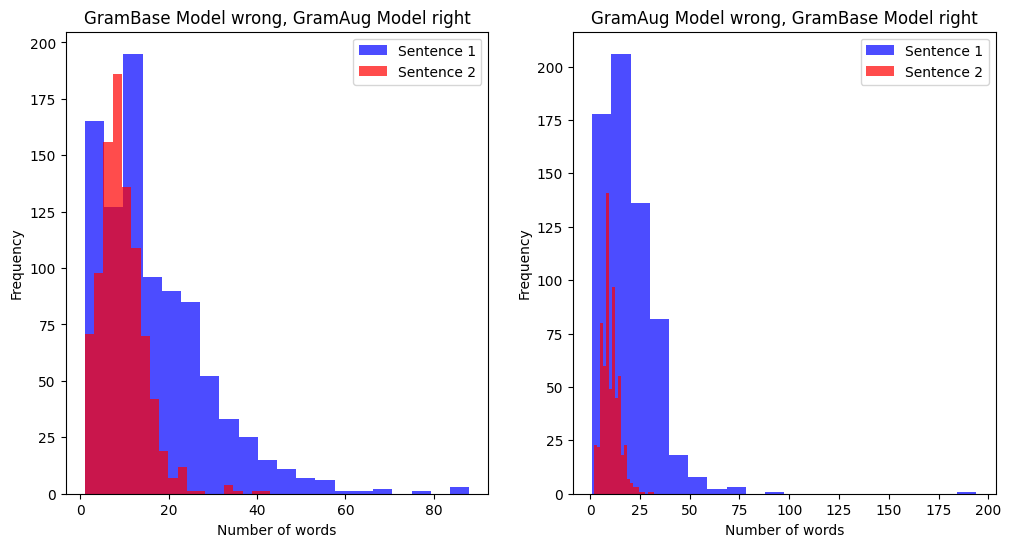

In [30]:
model1_name, model2_name, entailments, contradictions, neutrals, entailments2, contradictions2, neutrals2, correct_predictions_aug_wrong_base_df, correct_predictions_base_wrong_aug_df = get_model_diffs(gram_base_correct_preds, gram_base_wrong_preds, gram_aug_correct_preds, gram_aug_wrong_preds, "GramBase Model", "GramAug Model")
neg_diffs(model1_name, model2_name, correct_predictions_aug_wrong_base_df, correct_predictions_base_wrong_aug_df)
plot_diffs(model1_name, model2_name, entailments, neutrals, contradictions, entailments2, neutrals2, contradictions2)
plot_word_length_diffs(model1_name, model2_name, correct_predictions_base_wrong_aug_df, correct_predictions_aug_wrong_base_df)

# Do the prediction spreads look like the training spreads (is the model *doing* anything with the negations)?

In [31]:
# look into how many of the 2371 examples have both sentences w negation versus just one of the two

negations = ['neither', 'never', 'no one', 'nobody', 'none', 'nor', 'nothing', 'nowhere', "isn't", "doesn't", "hasn't", "not", "no", "can't", "won't", "shouldn't", "wouldn't", "couldn't", "don't", "didn't", "aren't", "wasn't", "weren't", "isn't", "aren't", "wasn't", "weren't", "hasn't", "haven't", "hadn't", "won't", "wouldn't", "shan't", "shouldn't", "mustn't", "needn't", "mightn't"]

def check_label_spread(negation_dataset):
    sent1_neg = []
    sent2_neg = []
    both_neg = []
    for datum in negation_dataset:
        sent1 = datum.get_sent1()
        sent2 = datum.get_sent2()
        if any(negation in sent1 for negation in negations) and any(negation in sent2 for negation in negations):
            both_neg.append(datum)
        elif any(negation in sent1 for negation in negations) and not any(negation in sent2 for negation in negations):
            sent1_neg.append(datum)
        elif not any(negation in sent1 for negation in negations) and any(negation in sent2 for negation in negations):
            sent2_neg.append(datum)

    # print(f"Both sentences have negation: {len(both_neg)}")
    # print(f"Only sentence 1 has negation: {len(sent1_neg)}")
    # print(f"Only sentence 2 has negation: {len(sent2_neg)}")

    # count the number of entailments, contradictions and neutrals in each list

    def count_labels(data, name):
        entailments = 0
        contradictions = 0
        neutrals = 0
        for datum in data:
            label = datum.get_gold_label()
            if label == 'entailment':
                entailments += 1
            elif label == 'contradiction':
                contradictions += 1
            else:
                neutrals += 1
        # print(f'{name} has {entailments} entailments, {contradictions} contradictions, and {neutrals} neutrals')
        return entailments, contradictions, neutrals

    b_e, b_c, b_n = count_labels(both_neg, 'Both neg')
    s1_e, s1_c, s1_n = count_labels(sent1_neg, 'Sent1 neg')
    s2_e, s2_c, s2_n = count_labels(sent2_neg, 'Sent2 neg')

    fig, ax = plt.subplots(1, 1, figsize=(8, 6))

    # Adjust the width and spacing of the bars
    bar_width = 0.2
    spacing = 0.1

    # Plot data_lists -- negations and number of each label in each list
    ax.bar(np.arange(3), [len(both_neg), len(sent1_neg), len(sent2_neg)], width=bar_width, color='b', alpha=.7, label='Negation')
    ax.bar(np.arange(3) + bar_width, [b_e, s1_e, s2_e], width=bar_width, color='g', alpha=.7, label='Entailments')
    ax.bar(np.arange(3) + 2 * bar_width, [b_c, s1_c, s2_c], width=bar_width, color='r', alpha=.7, label='Contradictions')
    ax.bar(np.arange(3) + 3 * bar_width, [b_n, s1_n, s2_n], width=bar_width, color='orange', alpha=.7, label='Neutrals')

    # band aid solution to getting the total counts
    x=0
    y=0
    z=0
    # add labels in middle of each bar
    for i, v in enumerate([len(both_neg), len(sent1_neg), len(sent2_neg)]):
        if i == 0:
            x = v
        if i == 1:
            y = v
        if i == 2:
            z = v
        ax.text(i, v/2, str(v), color='black', ha='center')

    for i, v in enumerate([b_e, s1_e, s2_e]):
        ax.text(i + bar_width, v/2, str(v), color='black', ha='center')
        if i ==0:
            a = x
        if i == 1:
            a = y
        if i == 2:
            a = z
        ax.text(i + bar_width, v, str(round((v/a)*100,1)), color='black', ha='center')

    for i, v in enumerate([b_c, s1_c, s2_c]):
        ax.text(i + 2 * bar_width, v/2, str(v), color='black', ha='center')
        if i ==0:
            a = x
        if i == 1:
            a = y
        if i == 2:
            a = z
        ax.text(i + 2*bar_width, v, str(round((v/a)*100,1)), color='black', ha='center')

    for i, v in enumerate([b_n, s1_n, s2_n]):
        ax.text(i + 3 * bar_width, v/2, str(v), color='black', ha='center')
        if i ==0:
            a = x
        if i == 1:
            a = y
        if i == 2:
            a = z
        ax.text(i + 3*bar_width, v, str(round((v/a)*100,1)), color='black', ha='center')

    x_tick1 = 'Both sentences'
    x_tick2 = 'Only sentence 1'
    x_tick3 = 'Only sentence 2'

    # Add labels and title
    ax.set_ylabel('Number of examples')
    ax.set_title('Negation in dataset')
    ax.set_xticks(np.arange(3) + bar_width + spacing)
    ax.set_xticklabels([x_tick1, x_tick2, x_tick3])
    ax.legend()

    # Show the plot
    plt.show()

# take the model predictions on the negative data and check the spread of predictions, comparing to the true labels
# checks spread of the guesses
def check_label_spread2(negation_dataset):
    sent1_neg = []
    sent2_neg = []
    both_neg = []
    for datum in negation_dataset:
        sent1 = datum[0]
        sent2 = datum[1]
        
        if any(negation in sent1 for negation in negations) and any(negation in sent2 for negation in negations):
            both_neg.append(datum)
        elif any(negation in sent1 for negation in negations) and not any(negation in sent2 for negation in negations):
            sent1_neg.append(datum)
        elif not any(negation in sent1 for negation in negations) and any(negation in sent2 for negation in negations):
            sent2_neg.append(datum)

    # print(f"Both sentences have negation: {len(both_neg)}")
    # print(f"Only sentence 1 has negation: {len(sent1_neg)}")
    # print(f"Only sentence 2 has negation: {len(sent2_neg)}")

    # count the number of entailments, contradictions and neutrals in each list

    def count_labels_pred(data):
        entailments = 0
        contradictions = 0
        neutrals = 0
        for datum in data:
            pred_label = datum[2]
            if pred_label == 'entailment':
                entailments += 1
            elif pred_label == 'contradiction':
                contradictions += 1
            else:
                neutrals += 1
        return entailments, contradictions, neutrals
    
    def count_labels_true(data):
        entailments = 0
        contradictions = 0
        neutrals = 0
        for datum in data:
            label = datum[3]
            if label == 'entailment':
                entailments += 1
            elif label == 'contradiction':
                contradictions += 1
            else:
                neutrals += 1
        return entailments, contradictions, neutrals

    b_e, b_c, b_n = count_labels_pred(both_neg)
    s1_e, s1_c, s1_n = count_labels_pred(sent1_neg)
    s2_e, s2_c, s2_n = count_labels_pred(sent2_neg)

    b_et, b_ct, b_nt = count_labels_true(both_neg)
    s1_et, s1_ct, s1_nt = count_labels_true(sent1_neg)
    s2_et, s2_ct, s2_nt = count_labels_true(sent2_neg)


    fig, ax = plt.subplots(1, 1, figsize=(14, 6))

    bar_width = 0.125
    spacing = 0.3

    # Plot data_lists -- negations and number of each label in each list
    ax.bar(np.arange(3), [len(both_neg), len(sent1_neg), len(sent2_neg)], width=bar_width, color='b', alpha=.7, label='Negation')
    ax.bar(np.arange(3) + bar_width, [b_e, s1_e, s2_e], width=bar_width, color='g', alpha=.7, label='Entailments')
    ax.bar(np.arange(3) + 2 * bar_width, [b_c, s1_c, s2_c], width=bar_width, color='r', alpha=.7, label='Contradictions')
    ax.bar(np.arange(3) + 3 * bar_width, [b_n, s1_n, s2_n], width=bar_width, color='orange', alpha=.7, label='Neutrals')
    ax.bar(np.arange(3) + 4 *bar_width, [b_et, s1_et, s2_et], width=bar_width, color='g')
    ax.bar(np.arange(3) + 5 * bar_width, [b_ct, s1_ct, s2_ct], width=bar_width, color='r')
    ax.bar(np.arange(3) + 6 * bar_width, [b_nt, s1_nt, s2_nt], width=bar_width, color='orange')

    # add labels in middle of each bar
    x=0
    y=0
    z=0
    for i, v in enumerate([len(both_neg), len(sent1_neg), len(sent2_neg)]):
        if i == 0:
            x = v
        if i == 1:
            y = v
        if i == 2:
            z = v
        ax.text(i, v/2, str(v), color='black', ha='center')

    for i, v in enumerate([b_e, s1_e, s2_e]):
        ax.text(i + bar_width, v/2, str(v), color='black', ha='center')
        if i ==0:
            a = x
        if i == 1:
            a = y
        if i == 2:
            a = z
        ax.text(i + bar_width, v, str(round((v/a)*100,1)), color='black', ha='center')

    for i, v in enumerate([b_c, s1_c, s2_c]):
        ax.text(i + 2 * bar_width, v/2, str(v), color='black', ha='center')
        if i ==0:
            a = x
        if i == 1:
            a = y
        if i == 2:
            a = z
        ax.text(i + 2*bar_width, v, str(round((v/a)*100,1)), color='black', ha='center')

    for i, v in enumerate([b_n, s1_n, s2_n]):
        ax.text(i + 3 * bar_width, v/2, str(v), color='black', ha='center')
        if i ==0:
            a = x
        if i == 1:
            a = y
        if i == 2:
            a = z
        ax.text(i + 3*bar_width, v, str(round((v/a)*100,1)), color='black', ha='center')

    for i, v in enumerate([b_et, s1_et, s2_et]):
        ax.text(i + 4 * bar_width, v/2, str(v), color='black', ha='center')
        if i ==0:
            a = x
        if i == 1:
            a = y
        if i == 2:
            a = z
        ax.text(i + 4*bar_width, v, str(round((v/a)*100,1)), color='black', ha='center')

    for i, v in enumerate([b_ct, s1_ct, s2_ct]):
        ax.text(i + 5 * bar_width, v/2, str(v), color='black', ha='center')
        if i ==0:
            a = x
        if i == 1:
            a = y
        if i == 2:
            a = z
        ax.text(i + 5*bar_width, v, str(round((v/a)*100,1)), color='black', ha='center')

    for i, v in enumerate([b_nt, s1_nt, s2_nt]):
        ax.text(i + 6 * bar_width, v/2, str(v), color='black', ha='center')
        if i ==0:
            a = x
        if i == 1:
            a = y
        if i == 2:
            a = z
        ax.text(i + 6*bar_width, v, str(round((v/a)*100,1)), color='black', ha='center')

    x_tick1 = 'Both sentences'
    x_tick2 = 'Only sentence 1'
    x_tick3 = 'Only sentence 2'

    # Add labels and title
    ax.set_ylabel('Number of examples')
    ax.set_title('Predictions vs True labels spread (test data)')
    ax.set_xticks(np.arange(3) + bar_width + spacing)
    ax.set_xticklabels([x_tick1, x_tick2, x_tick3])
    ax.legend()

    # Show the plot
    plt.show()

In [32]:
def plot_cosine_sims(data, option='all'):
    tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')

    
    # Plot the average cosine similarity between sentence pairs by label
    entailment_cosine = []
    contradiction_cosine = []
    neutral_cosine = []

    option_neg = []
    for datum in tqdm(data):
        # if datum is a list of strings
        if isinstance(datum, list):
            sent1 = datum[0]
            sent2 = datum[1]
            label = datum[2]
        else:
            sent1 = datum.get_sent1()
            sent2 = datum.get_sent2()
            label = datum.get_gold_label()

        # implement this -- only make it so it shows the one we care about
        if option == 'all':
            option_neg.append(datum)
        if option == 'both':
            if any(negation in sent1 for negation in negations) and any(negation in sent2 for negation in negations):
                option_neg.append(datum)
        elif option == 'sent1':
            if any(negation in sent1 for negation in negations) and not any(negation in sent2 for negation in negations):
                option_neg.append(datum)
        elif option == 'sent2':
            if not any(negation in sent1 for negation in negations) and any(negation in sent2 for negation in negations):
                option_neg.append(datum)

    for datum in tqdm(option_neg):
        
        if isinstance(datum, list):
            sent1 = datum[0]
            sent2 = datum[1]
            label = datum[2]
        else:
            sent1 = datum.get_sent1()
            sent2 = datum.get_sent2()
            label = datum.get_gold_label()
        
        sent1_embedding = tokenizer(
            [sent1],
            padding='max_length',
            max_length=512,
            truncation=True,
            return_tensors='pt'
        )
        sent2_embedding = tokenizer(
            [sent2],
            padding='max_length',
            max_length=512,
            truncation=True,
            return_tensors='pt'
        )

        sent1_embedding = torch.tensor(sent1_embedding['input_ids']).float()
        sent2_embedding = torch.tensor(sent2_embedding['input_ids']).float()
        
        cosine_score = torch.cosine_similarity(sent1_embedding, sent2_embedding)
        if label == "entailment":
            entailment_cosine.append(cosine_score.item())
        elif label == "contradiction":
            contradiction_cosine.append(cosine_score.item())
        elif label == "neutral":
            neutral_cosine.append(cosine_score.item())

    # print the mean of each list
    print(f"Mean cosine similarity for entailment: {np.mean(entailment_cosine):.2f}")
    print(f"Mean cosine similarity for contradiction: {np.mean(contradiction_cosine):.2f}")
    print(f"Mean cosine similarity for neutral: {np.mean(neutral_cosine):.2f}")

    plt.hist(entailment_cosine, bins=20, alpha=0.5, label='entailment')
    plt.hist(contradiction_cosine, bins=20, alpha=0.5, label='contradiction')
    plt.hist(neutral_cosine, bins=20, alpha=0.5, label='neutral')
    plt.legend(loc='upper right')
    plt.xlabel('Cosine Similarity')
    plt.ylabel('Frequency')
    plt.title('Cosine Similarity Distribution by Label')    
    plt.show()


  0%|          | 0/97247 [00:00<?, ?it/s]/tmp/ipykernel_1743591/1304830230.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sent1_embedding = torch.tensor(sent1_embedding['input_ids']).float()
/tmp/ipykernel_1743591/1304830230.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sent2_embedding = torch.tensor(sent2_embedding['input_ids']).float()
 74%|███████▎  | 71514/97247 [00:43<00:15, 1618.06it/s]

100%|██████████| 97247/97247 [00:59<00:00, 1648.24it/s]


Mean cosine similarity for entailment: 0.43
Mean cosine similarity for contradiction: 0.42
Mean cosine similarity for neutral: 0.42


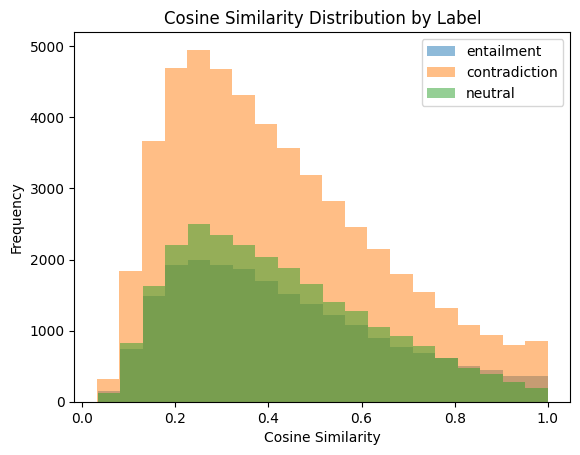

100%|██████████| 2371/2371 [00:01<00:00, 1674.82it/s]


Mean cosine similarity for entailment: 0.43
Mean cosine similarity for contradiction: 0.43
Mean cosine similarity for neutral: 0.41


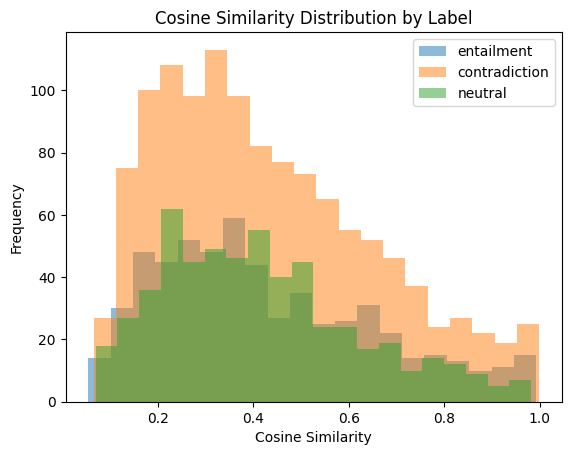

100%|██████████| 2371/2371 [00:01<00:00, 1653.76it/s]


Mean cosine similarity for entailment: 0.44
Mean cosine similarity for contradiction: 0.42
Mean cosine similarity for neutral: 0.43


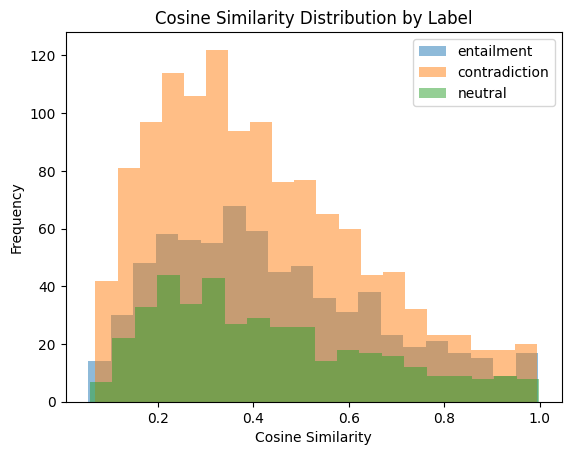

In [33]:
# get cosine similarity distributions in original dataset negations, test set negations and predictions on the negated test set
plot_cosine_sims(full_dataset_negations)
plot_cosine_sims(neg_dev_data)
plot_cosine_sims(base_correct_preds_neg+base_wrong_preds_neg)

  0%|          | 0/155248 [00:00<?, ?it/s]/tmp/ipykernel_1743591/1304830230.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sent1_embedding = torch.tensor(sent1_embedding['input_ids']).float()
/tmp/ipykernel_1743591/1304830230.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sent2_embedding = torch.tensor(sent2_embedding['input_ids']).float()
 42%|████▏     | 65642/155248 [00:40<00:54, 1654.85it/s]

100%|██████████| 155248/155248 [01:35<00:00, 1630.54it/s]


Mean cosine similarity for entailment: 0.42
Mean cosine similarity for contradiction: 0.42
Mean cosine similarity for neutral: 0.42


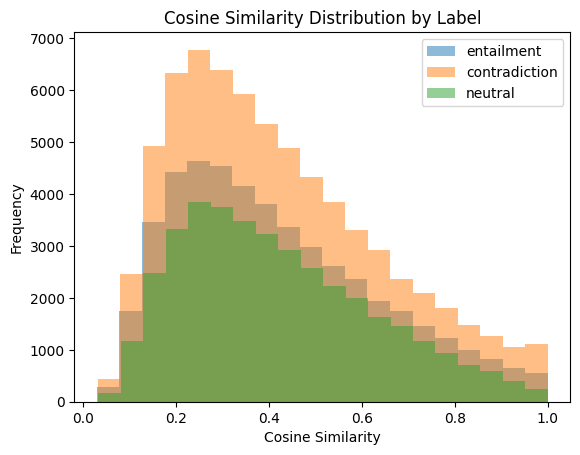

100%|██████████| 2371/2371 [00:01<00:00, 1630.94it/s]


Mean cosine similarity for entailment: 0.43
Mean cosine similarity for contradiction: 0.43
Mean cosine similarity for neutral: 0.41


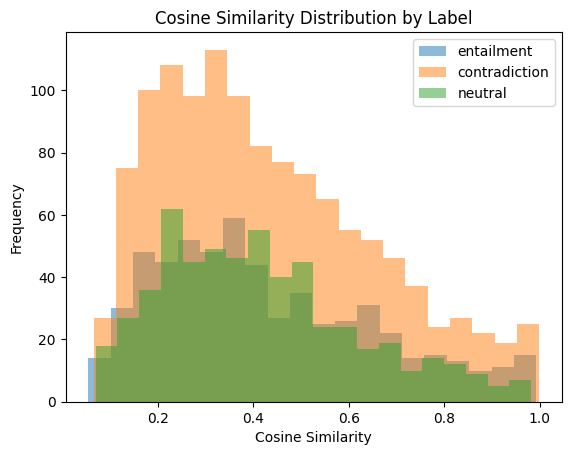

100%|██████████| 2371/2371 [00:02<00:00, 1139.87it/s]


Mean cosine similarity for entailment: 0.44
Mean cosine similarity for contradiction: 0.43
Mean cosine similarity for neutral: 0.41


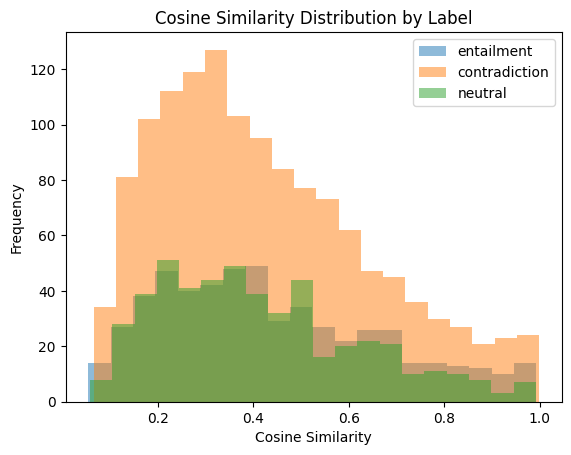

In [34]:
# get cosine similarity distributions in augmented dataset negations, test set negations and predictions on the negated test set
plot_cosine_sims(augmented_train_negations)
plot_cosine_sims(neg_dev_data)
plot_cosine_sims(aug_correct_preds_neg+aug_wrong_preds_neg)

Full dataset negations label spread


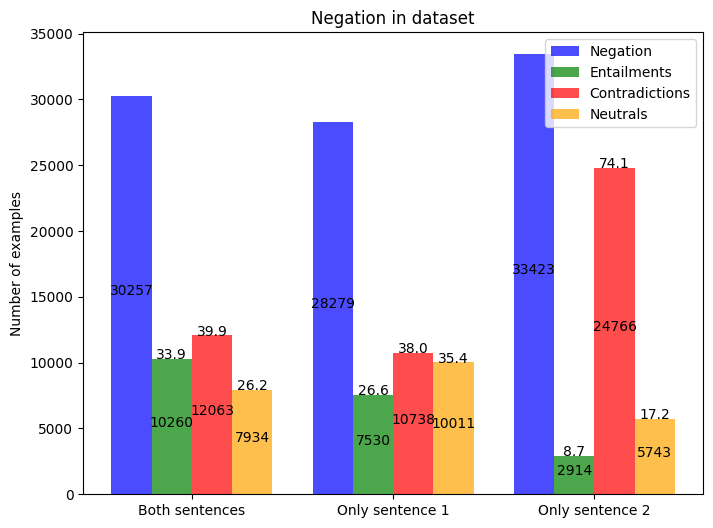

Base model predictions spread


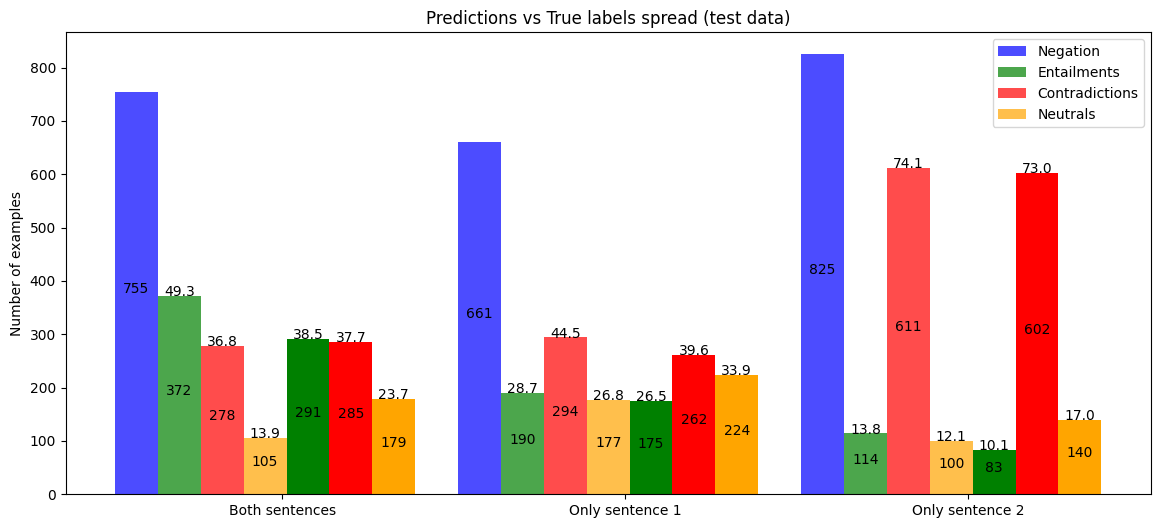

In [35]:
# check neg_dev_data, full_dataset_negations and grammatical_train_negations for their spread
# print('Neg dev data label spread')
# check_label_spread(neg_dev_data) # actual spread
print('Full dataset negations label spread')
check_label_spread(full_dataset_negations) # spread in training data

print('Base model predictions spread')
check_label_spread2(base_correct_preds_neg+base_wrong_preds_neg)



Augmented dataset negations label spread


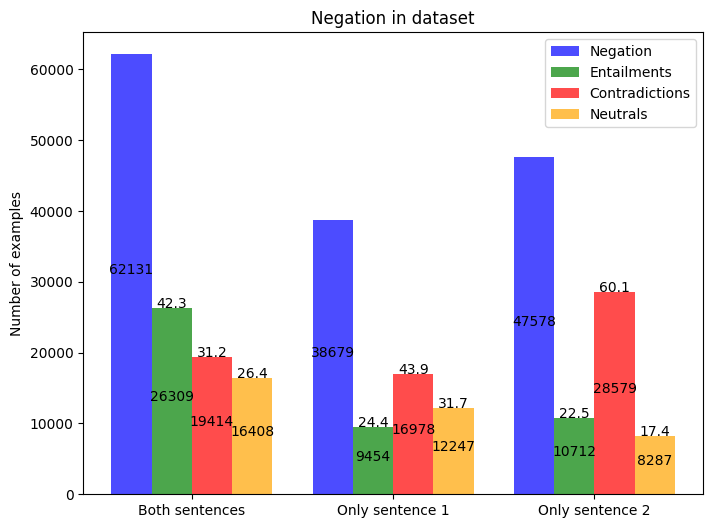

Aug model predictions spread


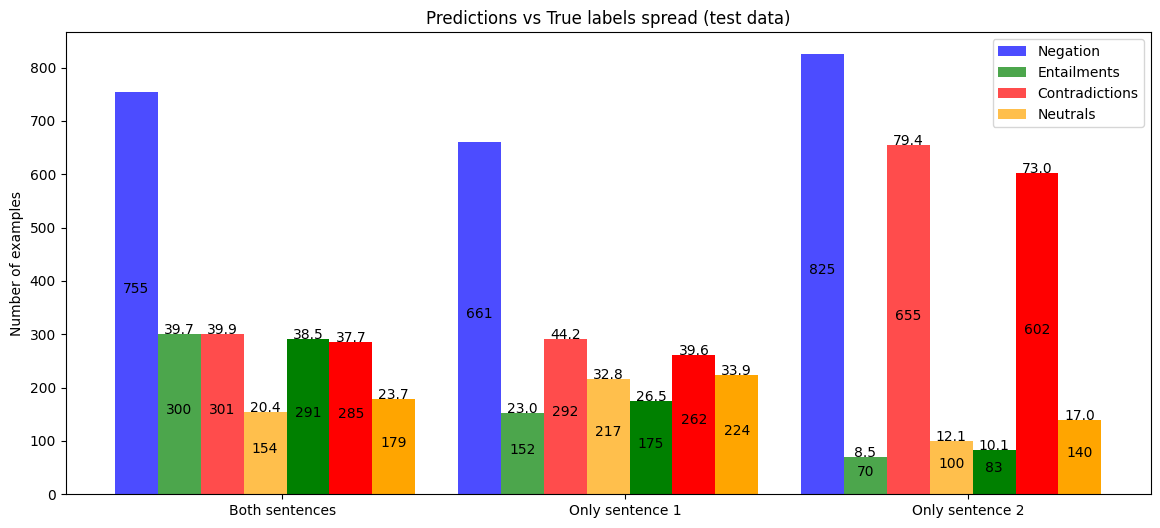

In [36]:
# print('Neg dev data label spread')
# check_label_spread(neg_dev_data) # actual spread
print('Augmented dataset negations label spread')
check_label_spread(augmented_train_negations) # spread in augmented data

print('Aug model predictions spread')
check_label_spread2(aug_correct_preds_neg+aug_wrong_preds_neg)

# So what's actually happening inside each layer?

In [44]:
from bertviz.neuron_view import show

tokenizer = distilbert_tokenizer
# sentence_a = "Frankly, I think we should invade Poland"
# sentence_b = "Leave Poland out of this, you son of a bitch"
sentence_a = "oh yeah all mine are uh purebreds so i keep them in"
sentence_b = "none of mine are mutts"

inputs = tokenizer.encode_plus(sentence_a, sentence_b, return_tensors='pt').to(Config.device)
input_ids = inputs['input_ids']
# token_type_ids = inputs['token_type_ids']

# Calculate the length of sentence A
length_sentence_a = len(distilbert_tokenizer.tokenize(sentence_a))

# Calculate the sentence_b_start index
sentence_b_start = input_ids[0].tolist().index(distilbert_tokenizer.sep_token_id) + 1


attention = distilbert_model(input_ids)[-1]
input_id_list = input_ids[0].tolist() # Batch index 0
tokens = tokenizer.convert_ids_to_tokens(input_id_list) 

print(test_model(sentence_a, sentence_b, gram_base_model))

head_view(attention, tokens, sentence_b_start)

#plot attention heatmap


contradiction


<IPython.core.display.Javascript object>

In [38]:
model_view(attention, tokens, sentence_b_start)

<IPython.core.display.Javascript object>

In [39]:
from transformers import DistilBertTokenizer, DistilBertModel
import torch
import numpy as np

labels = ['entailment', 'contradiction', 'neutral']

def compute_textual_saliency(model, tokenizer, sent1, sent2, label, relative_heat=False):
    encoded_sentence1 = tokenizer(
            [sent1],
            padding='max_length',
            max_length=512,
            truncation=True,
            return_tensors='pt'
        )

    token_list = []
    # count ever input id which is not '0', '101', or '102'
    token_count_sent1 = 0
    for i in range(len(encoded_sentence1['input_ids'][0])):
        if encoded_sentence1['input_ids'][0][i] not in [0]:
            token_count_sent1 += 1
            token_list.append(encoded_sentence1['input_ids'][0][i].item())

    encoded_sentence2 = tokenizer(
            [sent2],
            padding='max_length',
            max_length=512,
            truncation=True,
            return_tensors='pt'
        )
    
    # count ever input id which is not '0', '101', or '102'
    token_count_sent2 = 0
    for i in range(len(encoded_sentence2['input_ids'][0])):
        if encoded_sentence2['input_ids'][0][i] not in [0]:
            token_count_sent2 += 1
            token_list.append(encoded_sentence2['input_ids'][0][i].item())

    
    target = labels.index(label)
    target_array = [0] * 3
    target_array[target] = 1
    target_tensor = torch.tensor([target_array], dtype=torch.float, device="cuda:1")

    heatmap_data = []

    # Iterate through each token, skipping special tokens for masking
    for i, token_id in enumerate(token_list):
        
        
        if tokenizer.convert_ids_to_tokens(token_id) in ['[CLS]', '[SEP]', '[PAD]']:
            continue

        # recreate sentence with a single token masked
        token_list[i] = tokenizer.mask_token_id

        # put sentences back together, join as normal sentence (not perfect but more for viz sake)
        sent1_amended = " ".join(tokenizer.convert_ids_to_tokens(token_list[:token_count_sent1]))
        sent2_amended = " ".join(tokenizer.convert_ids_to_tokens(token_list[token_count_sent1:]))

        # new encoded sentences for model
        encoded_sentences = tokenizer(
            [sent1_amended, sent2_amended],
            padding='max_length',
            max_length=512,
            truncation=True,
            return_tensors='pt'
        )

        # Forward pass through the model to get logits
        outputs = model(sent1_amended, sent2_amended)

        # Compute loss (assuming CrossEntropyLoss)
        loss_function = torch.nn.CrossEntropyLoss()
        loss = loss_function(outputs.squeeze(), target_tensor.squeeze())  # Assuming label is provided

        # Compute gradient of of the output w respect to target (loss)
        # grad = torch.autograd.grad(loss, outputs)[0]

        # Compute saliency scores
        # saliency_scores = grad.norm(dim=-1)  # L2 norm of the gradients
        saliency_scores = loss.item()
        

        sentence_masked = ''
        sentence_number = 0
        if i<=token_count_sent1:
            sentence_masked = 'sentence 1,'
            sentence_number = 1
        else:
            sentence_masked = 'sentence 2,'
            sentence_number = 2
        
        # print(f'with {tokenizer.convert_ids_to_tokens(token_id)} masked in {sentence_masked} saliency is {saliency_scores[0]}\n\n')

        # Append saliency score for the masked token
        heatmap_data.append({
            'token': tokenizer.convert_ids_to_tokens(token_id),
            'meta': ['entailment', 'contradiction', 'neutral'],
            'sent_num': sentence_number,
            'heat': saliency_scores
        })
        
        heatmap_data.append({
            'token': " ",
            'meta': ["", "", ""],
            'sent_num': sentence_number,
            'heat': 0
        })
        
        token_list[i] = token_id

    print(heatmap_data)
    # normalize all the heatmap data 'heat' with the below formula
    # normalized_scores = (saliency_scores - min_val) / (max_val - min_val)
    max_heat = max([x['heat'] for x in heatmap_data])
    min_heat = min([x['heat'] for x in heatmap_data if x['heat'] != 0])

    if relative_heat:
        max_heat_sent1 = max([x['heat'] for x in heatmap_data if x['sent_num'] == 1])
        min_heat_sent1 = min([x['heat'] for x in heatmap_data if x['heat'] != 0 and x['sent_num'] == 1])
        max_heat_sent2 = max([x['heat'] for x in heatmap_data if x['sent_num'] == 2])
        min_heat_sent2 = min([x['heat'] for x in heatmap_data if x['heat'] != 0 and x['sent_num'] == 2])

        for i in range(len(heatmap_data)):
            if heatmap_data[i]['heat'] != 0:
                if heatmap_data[i]['sent_num'] == 1:
                    heatmap_data[i]['heat'] = (heatmap_data[i]['heat'] - min_heat_sent1) / (max_heat_sent1 - min_heat_sent1)
                else:
                    heatmap_data[i]['heat'] = (heatmap_data[i]['heat'] - min_heat_sent2) / (max_heat_sent2 - min_heat_sent2)
        return heatmap_data


    for i in range(len(heatmap_data)):
        if heatmap_data[i]['heat'] != 0:
            heatmap_data[i]['heat'] = (heatmap_data[i]['heat'] - min_heat) / (max_heat - min_heat)

    return heatmap_data

def plot_saliency(dbert_heatmap_data):
    # Extract tokens, heats, and meta from the data
    tokens = [d['token'] for d in dbert_heatmap_data]
    heats = [d['heat'] for d in dbert_heatmap_data]
    meta = [d['meta'] for d in dbert_heatmap_data]

    # Reshape heats to a 2D array for plotting
    heats_2d = np.array(heats).reshape((len(tokens) // 2, 2))  # Assuming two tokens per row

    # Plot heatmap
    plt.figure(figsize=(10, 6))
    plt.imshow(heats_2d, cmap='hot', interpolation='nearest')

    # Customize ticks and labels
    plt.xticks(np.arange(2), ['', '']) 
    plt.yticks(np.arange(len(tokens) // 2), tokens[::2])  # Show every other token

    # Add color bar
    plt.colorbar(label='Saliency Score')

    # Add labels
    plt.xlabel('Sentences')
    plt.ylabel('Tokens')

    # Add title
    plt.title('Saliency Scores Heatmap')

    # Show plot
    plt.show()

base model predicts entailment, aug model predicts entailment
[{'token': 'none', 'meta': ['entailment', 'contradiction', 'neutral'], 'sent_num': 1, 'heat': 1.9400479793548584}, {'token': ' ', 'meta': ['', '', ''], 'sent_num': 1, 'heat': 0}, {'token': 'of', 'meta': ['entailment', 'contradiction', 'neutral'], 'sent_num': 1, 'heat': 1.2535858154296875}, {'token': ' ', 'meta': ['', '', ''], 'sent_num': 1, 'heat': 0}, {'token': 'mine', 'meta': ['entailment', 'contradiction', 'neutral'], 'sent_num': 1, 'heat': 1.2111387252807617}, {'token': ' ', 'meta': ['', '', ''], 'sent_num': 1, 'heat': 0}, {'token': 'are', 'meta': ['entailment', 'contradiction', 'neutral'], 'sent_num': 1, 'heat': 1.1522818803787231}, {'token': ' ', 'meta': ['', '', ''], 'sent_num': 1, 'heat': 0}, {'token': 'pure', 'meta': ['entailment', 'contradiction', 'neutral'], 'sent_num': 1, 'heat': 1.1699795722961426}, {'token': ' ', 'meta': ['', '', ''], 'sent_num': 1, 'heat': 0}, {'token': '##bre', 'meta': ['entailment', 'contrad

<IPython.core.display.Javascript object>

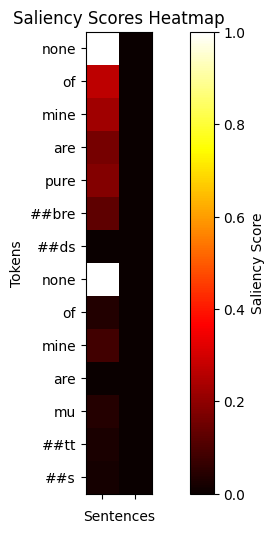

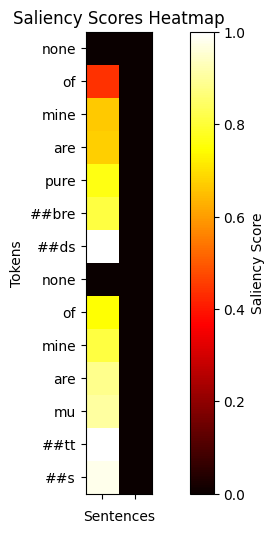

In [54]:
from textualheatmap import TextualHeatmap

# sent1 = "The sacred is not mysterious to her."
# sent2 = "The woman is familiar with the sacred."
sent1 = "oh yeah all mine are uh purebreds so i keep them in"
sent2 = "none of mine are mutts"
label = 'entailment'
label2 = 'contradiction'

print(f'base model predicts {test_model(sent1, sent2, gram_base_model)}, aug model predicts {test_model(sent1, sent2, gram_aug_model)}')

distilbert_tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
# dbert_heatmap_data = compute_textual_saliency(gram_base_model, distilbert_tokenizer, sent1, sent2, label, relative_heat=True)
dbert_heatmap_data = compute_textual_saliency(gram_base_model, distilbert_tokenizer, sent1, sent2, label, relative_heat=True)
dbert_heatmap_data2 = compute_textual_saliency(gram_aug_model, distilbert_tokenizer, sent1, sent2, label2, relative_heat=True)
heatmap = TextualHeatmap(facet_titles=['DistilBERT'], show_meta=True)
heatmap.set_data([dbert_heatmap_data])

display(heatmap)
plot_saliency(dbert_heatmap_data)
plot_saliency(dbert_heatmap_data2)

In [74]:
def get5(correct, wrong):
    a = []
    for datum in correct:
        a.append((datum[0],datum[1]))
    
    p = []
    for pred in wrong:
        if (pred[0], pred[1]) in a:
            p.append(pred)

    random.shuffle(p)
    for i in range(5):
        print(p[i])

# # get 5 examples each where aug model is right but base is wrong (neg)
# print(f'Aug model right, base wrong:')
# print(f'Sent1\tSent2\tBase Predicted\tTrue Label')
# get5(aug_correct_preds_neg, base_wrong_preds_neg)

# # get 5 examples each where base model is right but aug is wrong (neg)
# print(f'\nBase model right, aug wrong:')
# print(f'Sent1\tSent2\tAug Predicted\tTrue Label')
# get5(base_correct_preds_neg, aug_wrong_preds_neg)

# print(f'\nBoth models wrong:')
# print(f'Sent1\tSent2\tPredicted\tTrue Label')
# get5(base_wrong_preds_neg, aug_wrong_preds_neg)

# print(f"\nBoth models correct")
# print(f'Sent1\tSent2\tPredicted\tTrue Label')
# get5(base_correct_preds_neg, aug_correct_preds_neg)


print(f'\nBoth models wrong:')
print(f'Sent1\tSent2\tPredicted\tTrue Label')
get5(gram_base_wrong_preds_neg, gram_aug_wrong_preds_neg)

print(f"\nBoth models correct")
print(f'Sent1\tSent2\tPredicted\tTrue Label')
get5(gram_base_correct_preds_neg, gram_aug_correct_preds_neg)


Both models wrong:
Sent1	Sent2	Predicted	True Label
["that's true i didn't think about that", "That's not true.", 'entailment', 'contradiction']
['No money no results!" Another voice which Tommy rather thought was that of Boris replied: "Will you guarantee that there ARE results?"', 'Money will give results if there is enough of it. ', 'entailment', 'neutral']
["The islands' names refer to the different force winds hitting them, not their topography.", 'The name of the islands are based on their topography.', 'neutral', 'contradiction']
['But overinterpretation or even misinterpretation are not the same as bias.', '"You\'re not being overinterpreted or misinterpreted." she claimed. ', 'entailment', 'neutral']
['For instance, when Clinton cited executive privilege as a reason for holding back a memo from FBI Director Louis Freeh criticizing his drug policies, Bob Dole asserted that the president had no basis for refusing to divulge it.', 'Bob Dole stated that Clinton had no right to pr

In [71]:
negator = Negator(use_transformers=True, use_gpu=True, fail_on_unsupported=True)
title = "attention is all you need"
print(negator.negate_sentence(title))


Attention isn't all you need
